# **MODELO DE PREDICCIÓN DE LA DEMANDA UTILIZANDO ARIMA, SARIMA Y LIGHT GRADIENT BOOSTING MACHINE EN ENTORNOS INTERMITENTES PARA LA PLANIFICACIÓN EFICIENTE DE INVENTARIOS**

## **Importar librerías:**

In [3]:
#Importar librerías:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from summarytools import dfSummary
from sklearn.preprocessing import LabelEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from lightgbm import LGBMRegressor
import itertools
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats.mstats import winsorize
from statsmodels.stats.diagnostic import het_breuschpagan
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

## **Cargar los conjuntos de datos:**

In [5]:
#Cargar los 3 conjuntos de datos
sales_data = pd.read_csv('sales.csv')
calendar_data = pd.read_csv('calendar.csv')
prices_data = pd.read_csv('sell_prices.csv')

In [6]:
#Visualizar las primeras filas del conjunto sales
sales_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [7]:
#Visualizar las primeras filas del conjunto calendar
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [8]:
#Visualizar las primeras filas del conjunto prices
prices_data.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [9]:
#Visualizar la información básica del conjunto sales
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [10]:
#Visualizar la información básica del conjunto calendar
calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [11]:
#Visualizar la información básica del conjunto prices
prices_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


## **Pre-procesamiento de los datos:**

### Transformar el conjunto de datos "sales" de formato ancho a formato largo:

In [14]:
# Transformar las columnas 'd_1', 'd_2', ..., 'd_1913' de la tabla "sales_train_eval_df" en una sola columna 'day'
sales_data_melted = pd.melt(sales_data, 
                            id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                            var_name='d', 
                            value_name='sales')
sales_data_melted.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


### Unir los conjuntos de datos:

In [16]:
# Unión izquierda de los archivos "sales" y "calendar" a través de la veriable en común "d" 
merged_data = pd.merge(sales_data_melted, calendar_data, on='d', how='left')
merged_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0


In [17]:
# Unión izquierda del archivo "prices" considerando las varaibles comunes "store_id" ; "item_id" y "wm_yr_wk".
final_data = pd.merge(merged_data, prices_data, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])
final_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [18]:
# Visualizar la información básica del conjunto de datos "final_data"
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58327370 entries, 0 to 58327369
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 9.6+ GB


### Filtrar una sola tienda: "CA_1"

In [20]:
#Filtrar el conjunto de datos para quedarnos únicamente con la tienda "CA_1"
df_filtered = final_data[final_data['store_id'] == 'CA_1']

In [21]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5832737 entries, 0 to 58299928
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   d             object 
 7   sales         int64  
 8   date          object 
 9   wm_yr_wk      int64  
 10  weekday       object 
 11  wday          int64  
 12  month         int64  
 13  year          int64  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int64  
 19  snap_TX       int64  
 20  snap_WI       int64  
 21  sell_price    float64
dtypes: float64(1), int64(8), object(13)
memory usage: 1023.5+ MB


### Filtrar los últimos 3 años:

In [23]:
df_filtered["date"] = pd.to_datetime(df_filtered["date"])

In [24]:
# Definir el rango de tiempo para los últimos 3 años
end_date = df_filtered['date'].max()  # Fecha máxima en el dataset
start_date = end_date - pd.DateOffset(years=3)  # Fecha 3 años antes de la fecha máxima

# Filtrar el dataset para incluir solo los registros de los últimos 3 años
df_last_3_years = df_filtered[df_filtered['date'] >= start_date]

df_last_3_years.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
24879840,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_817,0,2013-04-24,11313,...,4,2013,NaN,NaN,NaN,NaN,0,0,0,NaN
24879841,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_817,0,2013-04-24,11313,...,4,2013,NaN,NaN,NaN,NaN,0,0,0,3.97
24879842,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_817,0,2013-04-24,11313,...,4,2013,NaN,NaN,NaN,NaN,0,0,0,NaN
24879843,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_817,2,2013-04-24,11313,...,4,2013,NaN,NaN,NaN,NaN,0,0,0,4.64
24879844,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_817,1,2013-04-24,11313,...,4,2013,NaN,NaN,NaN,NaN,0,0,0,3.08


In [25]:
df_last_3_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344753 entries, 24879840 to 58299928
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       object        
 2   dept_id       object        
 3   cat_id        object        
 4   store_id      object        
 5   state_id      object        
 6   d             object        
 7   sales         int64         
 8   date          datetime64[ns]
 9   wm_yr_wk      int64         
 10  weekday       object        
 11  wday          int64         
 12  month         int64         
 13  year          int64         
 14  event_name_1  object        
 15  event_type_1  object        
 16  event_name_2  object        
 17  event_type_2  object        
 18  snap_CA       int64         
 19  snap_TX       int64         
 20  snap_WI       int64         
 21  sell_price    float64       
dtypes: datetime64[ns](1), float64(1), int64(8), object(12)
memory u

### Eliminar columnas innecesarias:

In [27]:
# Eliminar las columnas innecesarias
columns_to_drop = ['id', 'd', 'wm_yr_wk', 'weekday', 'snap_TX', 'snap_WI', 'store_id', 'state_id', 'wday', 'month', 'year']
df_last_3_years = df_last_3_years.drop(columns=columns_to_drop)

### Exportar el dataset final:

In [29]:
df_last_3_years.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344753 entries, 24879840 to 58299928
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   item_id       object        
 1   dept_id       object        
 2   cat_id        object        
 3   sales         int64         
 4   date          datetime64[ns]
 5   event_name_1  object        
 6   event_type_1  object        
 7   event_name_2  object        
 8   event_type_2  object        
 9   snap_CA       int64         
 10  sell_price    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 306.2+ MB


In [30]:
df_last_3_years.to_csv("5_1S_3YEARS_FIN.csv", index=False)

### Generalidades del conjunto de datos final:

In [32]:
#Cargar el dataset
df = pd.read_csv('5_1S_3YEARS_FIN.csv')

In [33]:
df.head()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,3.97
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,2,2013-04-24,NaN,NaN,NaN,NaN,0,4.64
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,1,2013-04-24,NaN,NaN,NaN,NaN,0,3.08


In [34]:
df.tail()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
3344748,FOODS_3_823,FOODS_3,FOODS,1,2016-04-24,NaN,NaN,NaN,NaN,0,2.98
3344749,FOODS_3_824,FOODS_3,FOODS,0,2016-04-24,NaN,NaN,NaN,NaN,0,2.48
3344750,FOODS_3_825,FOODS_3,FOODS,2,2016-04-24,NaN,NaN,NaN,NaN,0,3.98
3344751,FOODS_3_826,FOODS_3,FOODS,0,2016-04-24,NaN,NaN,NaN,NaN,0,1.28
3344752,FOODS_3_827,FOODS_3,FOODS,21,2016-04-24,NaN,NaN,NaN,NaN,0,1.00


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344753 entries, 0 to 3344752
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       object 
 1   dept_id       object 
 2   cat_id        object 
 3   sales         int64  
 4   date          object 
 5   event_name_1  object 
 6   event_type_1  object 
 7   event_name_2  object 
 8   event_type_2  object 
 9   snap_CA       int64  
 10  sell_price    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 280.7+ MB


In [36]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,item_id[object],1. HOBBIES_1_0012. FOODS_2_2103. FOODS_2_2014. FOODS_2_2025. FOODS_2_2036. FOODS_2_2047. FOODS_2_2058. FOODS_2_2069. FOODS_2_20710. FOODS_2_20811. other,"1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)1,097 (0.0%)3,333,783 (99.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAADQklEQVR4nO3cwWkbYRRG0TdCJPZGQghUQtKDisg2HauINGGkReJ44yyCS8gdmJxTwb+48BDMp+X9/X2gsFv7Afw/xEZGbGTERkZsZMRGRmxkxEZGbGTERma3LMvXZVme1n4I27ebmS8z83nth7B9zigZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkdnNzI+Z+b32Q9i+xb8YUXFGyYiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZgxcyBi9knFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyIiNjHUVGesqMs4oGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNj8ELG4IWMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVknFEyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhklIzYyYiNjXUXGuoqMM0pGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsa6iox1FRlnlIzYyBi8kDF4IeOMkhEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRMXghY/BCxhkls8zM88x8WvshbN7b/nw+fzscDqe1X8K2PR6Pl/3hcDhdr9dfx+Pxde0HsU33+/3pdrud9jMzx+Px9XK5/Fz7UWzasx8IZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZPYzfz8BWfshbNdHX8v5fP7u40n+tcfj8eKzcCpv1lVk/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiPzB0WpV2yec8bJAAAAAElFTkSuQmCC"">",0(0.0%)
2,dept_id[object],1. FOODS_32. HOUSEHOLD_13. HOUSEHOLD_24. HOBBIES_15. FOODS_26. FOODS_17. HOBBIES_2,"902,831 (27.0%)583,604 (17.4%)564,955 (16.9%)456,352 (13.6%)436,606 (13.1%)236,952 (7.1%)163,453 (4.9%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAChCAYAAADQgM1HAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC6ElEQVR4nO3bQU7bUABF0Z8qqtpJIoTEYlhEF9tFZDcI4UFbMUkHHUJCIM41Vc5ZwR9cfcuW32q/3w8ofFn6AFwPsZERGxmxkREbmdUY4/sY4+vSBznB836//730Ifi49e3t7Y/NZnOz9EHeMk3T42q1+im4/9d6s9nc3N/f/95ut3+WPswhT09P33a73c3Dw8PXMYbY/lPrMcbYbrd/7u7ufi19mDd8X/oAnMcLAhmxkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERG5n1GP9+4Vn6IMd89vNxmvU0TY+73e5mfPJfeKZpehxjPC99Dj7Ob+FkVhbxVOqbze10xdLBi9HKdcsGL0Yr1IOXT/3Gy2X5qEtGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSydZWFFOm6ykLqutkgkLGuIlPebG61K5etqyyrSNZVllWM0a6rLKuunI+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZJLBi7ELY4SDF2MX/BZOxuCFjBcEMpd6jHpk8sJF1lWWVLxm9nWVJRWHXGpdZUnFC14QyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyMy+rrKk4pCLrKssqXiN38LJWFeRucTN5lbjVbMPXoxdOGTWwYuxC8dcYvBi7MKrfNQlIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjM+vgxdiFY2YfvBi7cIjfwskYvJDxgkDmvY9Rj0g+7F3rKsspznHyuspyinO9d11lOcWHeUEgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc/K6ynKKc71rXWU5xTn8Fk7GuorMKTeb24xZvDl4MXJhLkcHL0YuzOmUwYuRC7PwUZeM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgcXVdZVDGnN9dVFlXMxQaBjHUVGS8IZMRGRmxkxEbmL1BveRU3hGGSAAAAAElFTkSuQmCC"">",0(0.0%)
3,cat_id[object],1. FOODS2. HOUSEHOLD3. HOBBIES,"1,576,389 (47.1%)1,148,559 (34.3%)619,805 (18.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABl0lEQVR4nO3bQWrbYBSF0aciQjORMAYvxovIYrsI7cYYa9CETNRBx4FAwv3/SOes4Nl82Mj4Dtu2FST8an0AxzFU1XNVPbU+pHPv27a9tj7ipxvP5/PLNE2n1of0bF3X+zAMfwT3NeM0Tafr9fo6z/Nb62N69Hg8fi/Lcrrdbk9VJbYvGKuq5nl+u1wuf1sf07Hn1gfsgQcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVf//s9X6kF55b77PuK7rfVmWU/nP1ofWdb1X1XvrO346G4TPsUH4BoMpHyl7/WTzSdShXa6rrKH6tLt1lTVUv/a6rvJk3SE/6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjZnfrqj29lr3Z5brKGqpPNgjEWFcR4wGBmFZfo77mDqjJlM/U7pjiUz5Tu+NqNeXbzc8sfJ4HBGLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIjRmzExKd

In [37]:
# Filtrar los datos para la categoría "FOODS"
df_foods_items = df[df['cat_id'] == 'FOODS']

# Contar el número de item_id únicos en la categoría FOODS
num_unique_items_foods = df_foods_items['item_id'].nunique()

# Mostrar el resultado
print(f"El número de productos únicos en la categoría FOODS es: {num_unique_items_foods}")

El número de productos únicos en la categoría FOODS es: 1437


## **Limpieza de datos:**

### Manejo de valores faltantes o nulos:

In [40]:
# Explorar los valores faltantes
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(df)) * 100

print("Valores faltantes en cada columna:")
print(missing_data)
print("\nPorcentaje de valores faltantes en cada columna:")
print(missing_percentage)

Valores faltantes en cada columna:
event_name_2    3335606
event_type_2    3335606
event_name_1    3082539
event_type_1    3082539
sell_price       202055
item_id               0
dept_id               0
cat_id                0
sales                 0
date                  0
snap_CA               0
dtype: int64

Porcentaje de valores faltantes en cada columna:
event_name_2    99.726527
event_type_2    99.726527
event_name_1    92.160438
event_type_1    92.160438
sell_price       6.040954
item_id          0.000000
dept_id          0.000000
cat_id           0.000000
sales            0.000000
date             0.000000
snap_CA          0.000000
dtype: float64


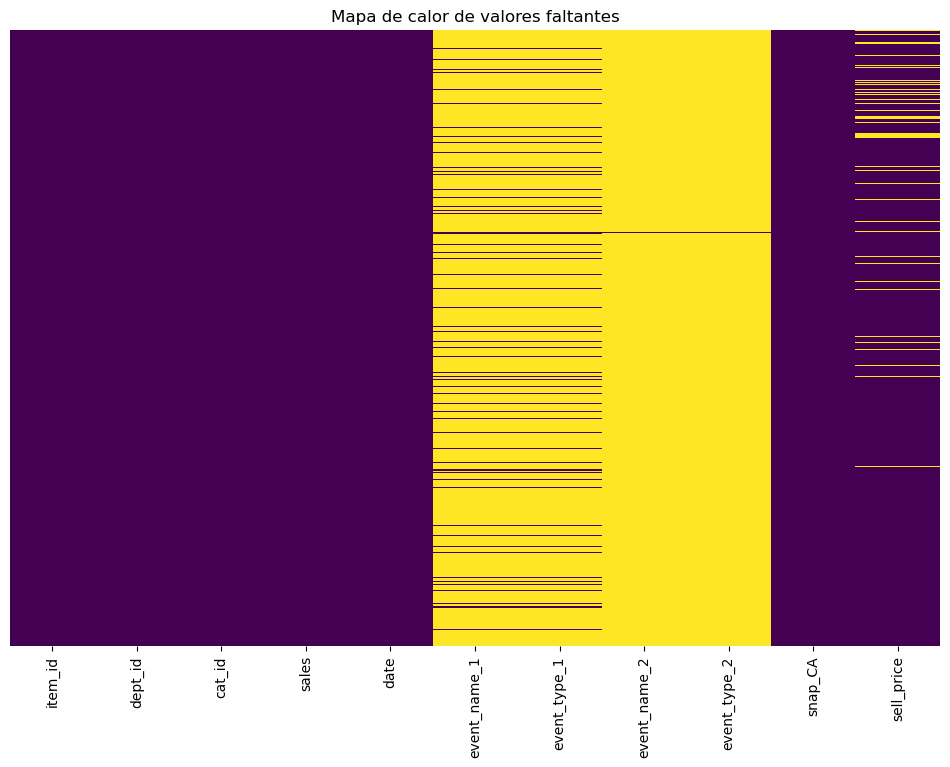

In [41]:
# Visualizar valores faltantes
# Mapa de calor de los valores faltantes
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title('Mapa de calor de valores faltantes')
plt.show()

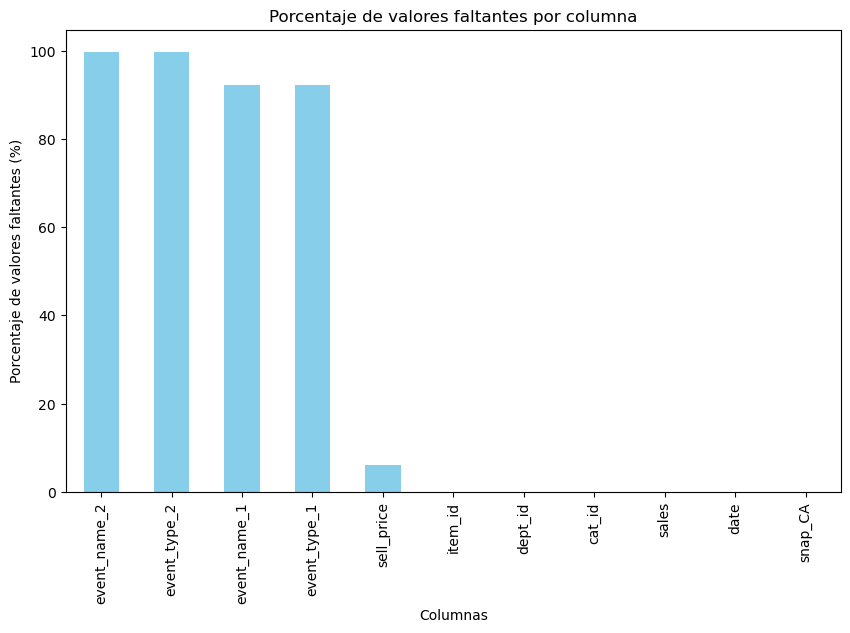

In [42]:
# Gráfico de barras del porcentaje de valores faltantes por columna
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de valores faltantes por columna')
plt.ylabel('Porcentaje de valores faltantes (%)')
plt.xlabel('Columnas')
plt.show()

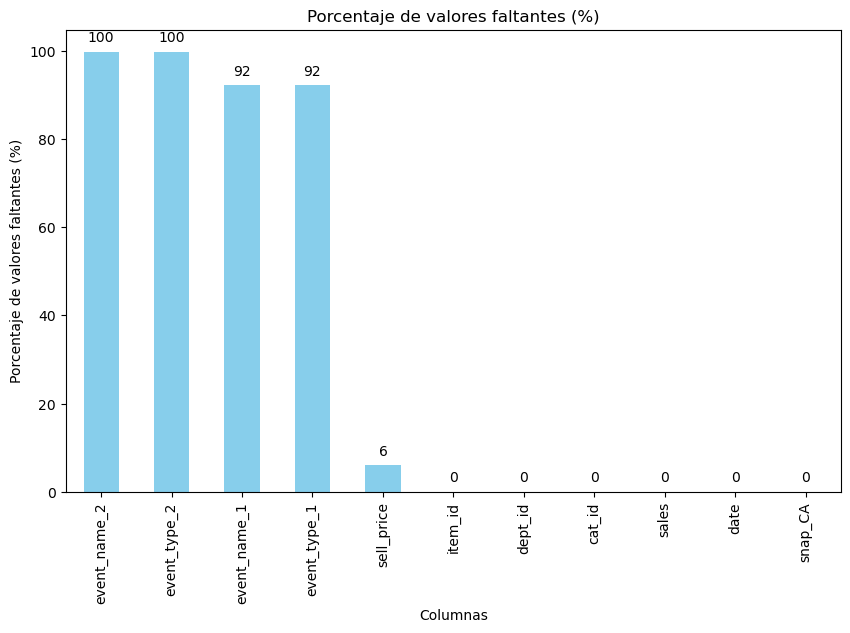

In [43]:
# Gráfico de barras del porcentaje de valores faltantes por columna con etiquetas
plt.figure(figsize=(10, 6))
ax = missing_percentage.plot(kind='bar', color='skyblue')
plt.title('Porcentaje de valores faltantes (%)')
plt.ylabel('Porcentaje de valores faltantes (%)')
plt.xlabel('Columnas')

# Añadir etiquetas encima de cada barra con 0 valores decimales
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points')

plt.show()

#### Nulos en la variable "sell_price":

In [45]:
# Filtrar las filas donde la columna 'sell_price' tiene valores faltantes
missing_sell_price_data = df[df['sell_price'].isnull()]

# Mostrar las primeras filas para observar los datos
missing_sell_price_data.head()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
25,HOBBIES_1_026,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
26,HOBBIES_1_027,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN
32,HOBBIES_1_033,HOBBIES_1,HOBBIES,0,2013-04-24,NaN,NaN,NaN,NaN,0,NaN


In [46]:
# Filtrar registros donde el item_id es "HOBBIES_1_001" y sell_price no es nulo
hobbies_1_001_with_price = df[(df['item_id'] == "HOBBIES_1_001") & (df['sell_price'].notnull())]

# Mostrar las primeras filas para revisar
hobbies_1_001_with_price.head()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
243920,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-07-13,NaN,NaN,NaN,NaN,0,9.58
246969,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-07-14,NaN,NaN,NaN,NaN,0,9.58
250018,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-07-15,NaN,NaN,NaN,NaN,0,9.58
253067,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-07-16,NaN,NaN,NaN,NaN,0,9.58
256116,HOBBIES_1_001,HOBBIES_1,HOBBIES,0,2013-07-17,NaN,NaN,NaN,NaN,0,9.58


In [47]:
# Imputar los valores faltantes de sell_price con la mediana por item_id
df['sell_price'] = df.groupby('item_id')['sell_price'].transform(lambda x: x.fillna(x.median()))

In [48]:
# Verificar si quedan valores faltantes en sell_price
df['sell_price'].isnull().sum()

0

In [49]:
# Volver a explorar los valores faltantes
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(df)) * 100

print("Valores faltantes en cada columna:")
print(missing_data)
print("\nPorcentaje de valores faltantes en cada columna:")
print(missing_percentage)

Valores faltantes en cada columna:
event_name_2    3335606
event_type_2    3335606
event_name_1    3082539
event_type_1    3082539
item_id               0
dept_id               0
cat_id                0
sales                 0
date                  0
snap_CA               0
sell_price            0
dtype: int64

Porcentaje de valores faltantes en cada columna:
event_name_2    99.726527
event_type_2    99.726527
event_name_1    92.160438
event_type_1    92.160438
item_id          0.000000
dept_id          0.000000
cat_id           0.000000
sales            0.000000
date             0.000000
snap_CA          0.000000
sell_price       0.000000
dtype: float64


#### Nulos en las variables de eventos:

In [51]:
# Comparar las ventas en días con eventos frente a días sin eventos
# Crear una columna binaria para indicar si hay un evento en el día
df['has_event'] = df['event_name_1'].notnull()

# Calcular las ventas promedio para los días con y sin eventos
avg_sales_with_event = df[df['has_event'] == True]['sales'].mean()
avg_sales_without_event = df[df['has_event'] == False]['sales'].mean()

# Mostrar resultados del análisis de ventas
print(f"Ventas promedio con eventos: {avg_sales_with_event}")
print(f"Ventas promedio sin eventos: {avg_sales_without_event}")

Ventas promedio con eventos: 1.328086982388431
Ventas promedio sin eventos: 1.4434587851118834


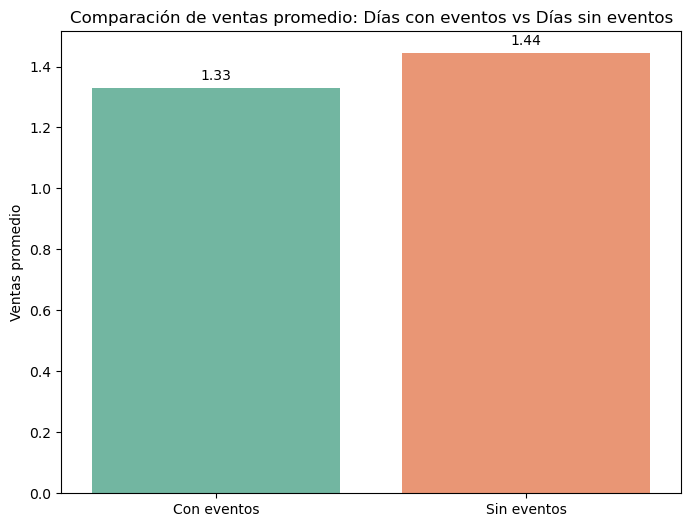

In [52]:
# Comparación de ventas promedio entre días con y sin eventos
avg_sales_with_event = df[df['has_event'] == True]['sales'].mean()
avg_sales_without_event = df[df['has_event'] == False]['sales'].mean()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=['Con eventos', 'Sin eventos'], y=[avg_sales_with_event, avg_sales_without_event], palette='Set2')
plt.title('Comparación de ventas promedio: Días con eventos vs Días sin eventos')
plt.ylabel('Ventas promedio')

# Añadir etiquetas en las barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.show()

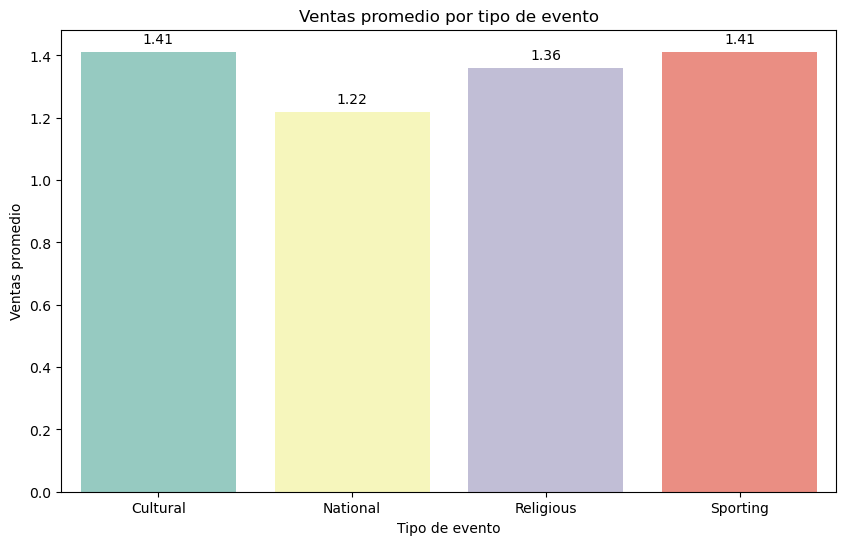

In [53]:
# Agrupar las ventas promedio por tipo de evento
event_sales = df[df['has_event'] == True].groupby('event_type_1')['sales'].mean().reset_index()

# Graficar las ventas promedio por tipo de evento
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='event_type_1', y='sales', data=event_sales, palette='Set3')
plt.title('Ventas promedio por tipo de evento')
plt.ylabel('Ventas promedio')
plt.xlabel('Tipo de evento')

# Añadir etiquetas en las barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

plt.show()

Claramente las columnas de eventos son variables binarias, donde un valor de 1 supone la existencia de algún evento en ese día específico y los valores nulos, que deberían estar rellenos con ceros, significan la ausencia de eventos. Ahora bien, como hemos podido evaluar, a primera vista no existe una diferencia significativa en las ventas comparando los días con eventos y los días sin eventos. No obstante, todavía no podemos comprobar la verdadera relevancia de las variables de eventos para los modelos predictivos, por lo que vamos a mantener estas columnas.

In [55]:
# Eliminar la columna 'has_event' del DataFrame, debido a que es redundante
df = df.drop(columns=['has_event'])

### Conversión de tipo de datos:

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344753 entries, 0 to 3344752
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   item_id       object 
 1   dept_id       object 
 2   cat_id        object 
 3   sales         int64  
 4   date          object 
 5   event_name_1  object 
 6   event_type_1  object 
 7   event_name_2  object 
 8   event_type_2  object 
 9   snap_CA       int64  
 10  sell_price    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 280.7+ MB


In [58]:
# Convertir la columna 'date' a tipo datetime.
df['date'] = pd.to_datetime(df['date'])

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344753 entries, 0 to 3344752
Data columns (total 11 columns):
 #   Column        Dtype         
---  ------        -----         
 0   item_id       object        
 1   dept_id       object        
 2   cat_id        object        
 3   sales         int64         
 4   date          datetime64[ns]
 5   event_name_1  object        
 6   event_type_1  object        
 7   event_name_2  object        
 8   event_type_2  object        
 9   snap_CA       int64         
 10  sell_price    float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 280.7+ MB


### Revisión de valores duplicados:

In [61]:
# Verificar si hay filas duplicadas en todo el dataset
duplicated_rows = df.duplicated()

# Contar el número de filas duplicadas
num_duplicated_rows = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicated_rows}")

# Mostrar las filas duplicadas si existen
df_duplicated = df[df.duplicated()]
print(df_duplicated)

Número de filas duplicadas: 0
Empty DataFrame
Columns: [item_id, dept_id, cat_id, sales, date, event_name_1, event_type_1, event_name_2, event_type_2, snap_CA, sell_price]
Index: []


## **Crear datasets filtrados para predicciones a nivel de categoría y de ítem:**

In [63]:
# Filtrar datos por categoría "FOODS" para predicciones a nivel de categoría.
df_foods = df[df['cat_id'] == 'FOODS'].copy()

# Filtrar datos por item_id "FOODS_2_347" para predicciones a nivel de ítem o producto.
df_foods_2_347 = df[df['item_id'] == 'FOODS_2_347'].copy()

In [64]:
df_foods.head()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
1612,FOODS_1_001,FOODS_1,FOODS,0,2013-04-24,NaN,NaN,NaN,NaN,0,2.24
1613,FOODS_1_002,FOODS_1,FOODS,0,2013-04-24,NaN,NaN,NaN,NaN,0,8.88
1614,FOODS_1_003,FOODS_1,FOODS,0,2013-04-24,NaN,NaN,NaN,NaN,0,2.88
1615,FOODS_1_004,FOODS_1,FOODS,7,2013-04-24,NaN,NaN,NaN,NaN,0,1.78
1616,FOODS_1_005,FOODS_1,FOODS,0,2013-04-24,NaN,NaN,NaN,NaN,0,3.28


In [65]:
df_foods.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1576389 entries, 1612 to 3344752
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   item_id       1576389 non-null  object        
 1   dept_id       1576389 non-null  object        
 2   cat_id        1576389 non-null  object        
 3   sales         1576389 non-null  int64         
 4   date          1576389 non-null  datetime64[ns]
 5   event_name_1  123582 non-null   object        
 6   event_type_1  123582 non-null   object        
 7   event_name_2  4311 non-null     object        
 8   event_type_2  4311 non-null     object        
 9   snap_CA       1576389 non-null  int64         
 10  sell_price    1576389 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 144.3+ MB


In [66]:
df_foods_2_347.head()

,item_id,dept_id,cat_id,sales,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,sell_price
2173,FOODS_2_347,FOODS_2,FOODS,3,2013-04-24,NaN,NaN,NaN,NaN,0,2.0
5222,FOODS_2_347,FOODS_2,FOODS,7,2013-04-25,NaN,NaN,NaN,NaN,0,2.0
8271,FOODS_2_347,FOODS_2,FOODS,4,2013-04-26,NaN,NaN,NaN,NaN,0,2.0
11320,FOODS_2_347,FOODS_2,FOODS,15,2013-04-27,NaN,NaN,NaN,NaN,0,2.0
14369,FOODS_2_347,FOODS_2,FOODS,9,2013-04-28,NaN,NaN,NaN,NaN,0,2.0


In [67]:
df_foods_2_347.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1097 entries, 2173 to 3343877
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   item_id       1097 non-null   object        
 1   dept_id       1097 non-null   object        
 2   cat_id        1097 non-null   object        
 3   sales         1097 non-null   int64         
 4   date          1097 non-null   datetime64[ns]
 5   event_name_1  86 non-null     object        
 6   event_type_1  86 non-null     object        
 7   event_name_2  3 non-null      object        
 8   event_type_2  3 non-null      object        
 9   snap_CA       1097 non-null   int64         
 10  sell_price    1097 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 102.8+ KB


## **Ingeniería de características:**

### Agregar variables relevantes para el conjunto de datos a nivel categoría:

In [70]:
# Realizar las agregaciones relevantes para la categoría "FOODS"
df_foods_agg = df_foods.groupby('date').agg({
    'sales': 'sum',  # Sumar ventas totales para cada fecha
    'sell_price': 'mean',  # Promedio de precios de venta
    'snap_CA': 'max',  # Máximo valor de snap_CA por semana (si hubo descuento)
    'event_name_1': lambda x: x.notnull().any().astype(int),  # Evento ocurrido en la semana
}).reset_index()

# Renombrar la columna de ventas a 'sales_total' y 'event_name_1' a 'has_event'
df_foods_agg.rename(columns={'sales': 'sales_total', 'event_name_1': 'has_event'}, inplace=True)

# Agregar variables de lag (desplazamiento de ventas)
df_foods_agg['sales_lag_1'] = df_foods_agg['sales_total'].shift(1)  # Lag de 1 día
df_foods_agg['sales_lag_2'] = df_foods_agg['sales_total'].shift(2)  # Lag de 2 días

# Rellenar valores NaN en sales_lag_1 y sales_lag_2 con el vecino más cercano
df_foods_agg['sales_lag_1'].fillna(method='bfill', inplace=True)
df_foods_agg['sales_lag_2'].fillna(method='bfill', inplace=True)

# Agregar variables de mes y semana del año
df_foods_agg['month'] = df_foods_agg['date'].dt.month
df_foods_agg['week_of_year'] = df_foods_agg['date'].dt.isocalendar().week

# Agregar promedio móvil de ventas (Media móvil de 4 días)
df_foods_agg['sales_moving_avg'] = df_foods_agg['sales_total'].rolling(window=4, min_periods=1).mean()

# Interacción de ventas con eventos
df_foods_agg['sales_event_interaction'] = df_foods_agg['sales_total'] * df_foods_agg['has_event']

# Interacción entre precio y promociones (snap_CA)
df_foods_agg['price_promo_interaction'] = df_foods_agg['sell_price'] * df_foods_agg['snap_CA']

# Tendencia acumulada de ventas (Cumulative Sales Trend)
df_foods_agg['cumulative_sales'] = df_foods_agg['sales_total'].cumsum()

# Días de la semana (Day of the Week)
df_foods_agg['day_of_week'] = df_foods_agg['date'].dt.dayofweek

# Desviación estándar del precio de venta (Price Volatility) (4 días)
df_foods_agg['price_volatility'] = df_foods_agg['sell_price'].rolling(window=4, min_periods=1).std()

# Rellenar valores NaN en price_volatility con el promedio de la columna
df_foods_agg['price_volatility'].fillna(df_foods_agg['price_volatility'].mean(), inplace=True)

# Estacionalidad anual (Quarter)
df_foods_agg['quarter'] = df_foods_agg['date'].dt.quarter

In [71]:
df_foods_agg.head()

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-04-24,2115,3.290077,0,0,2115.0,2115.0,4,17,2115.0,0,0.0,2115,2,0.000370,2
1,2013-04-25,2126,3.290077,0,0,2115.0,2115.0,4,17,2120.5,0,0.0,4241,3,0.000000,2
2,2013-04-26,2506,3.290077,0,0,2126.0,2115.0,4,17,2249.0,0,0.0,6747,4,0.000000,2
3,2013-04-27,3073,3.294551,0,0,2506.0,2126.0,4,17,2455.0,0,0.0,9820,5,0.002237,2
4,2013-04-28,3319,3.294551,0,0,3073.0,2506.0,4,17,2756.0,0,0.0,13139,6,0.002583,2


In [72]:
# Comprobar si hay valores nulos en el dataframe
null_values = df_foods_agg.isnull().sum()

# Mostrar los resultados
print("Valores nulos en el dataframe df_foods_agg:")
print(null_values)

Valores nulos en el dataframe df_foods_agg:
date                       0
sales_total                0
sell_price                 0
snap_CA                    0
has_event                  0
sales_lag_1                0
sales_lag_2                0
month                      0
week_of_year               0
sales_moving_avg           0
sales_event_interaction    0
price_promo_interaction    0
cumulative_sales           0
day_of_week                0
price_volatility           0
quarter                    0
dtype: int64


In [73]:
# Comprobar que los valores del dataset original y el nuevo dataset coincidan
# Agrupar el dataset original por fecha y categoría 'FOODS' para sumar las ventas
df_check_foods = df[df['cat_id'] == 'FOODS'].groupby('date')['sales'].sum().reset_index()

# Renombrar la columna de ventas para evitar confusión
df_check_foods.rename(columns={'sales': 'sales_real'}, inplace=True)

# Mostrar las primeras filas del dataframe para asegurarse de que esté correctamente agrupado
print(df_check_foods.head())

        date  sales_real
0 2013-04-24        2115
1 2013-04-25        2126
2 2013-04-26        2506
3 2013-04-27        3073
4 2013-04-28        3319


In [74]:
# Realizar la comparación entre las ventas reales y las agregadas
comparison_foods = df_check_foods.merge(df_foods_agg[['date', 'sales_total']], on='date', how='left')

# Crear una columna para calcular la diferencia entre las ventas reales y las agregadas
comparison_foods['difference'] = comparison_foods['sales_real'] - comparison_foods['sales_total']

# Verificar si hay diferencias
print("Comparación de ventas agregadas vs ventas reales:")
print(comparison_foods.head())
print("Diferencias encontradas:")
print(comparison_foods['difference'].sum())  # Esto debería ser 0 si las ventas coinciden

Comparación de ventas agregadas vs ventas reales:
        date  sales_real  sales_total  difference
0 2013-04-24        2115         2115           0
1 2013-04-25        2126         2126           0
2 2013-04-26        2506         2506           0
3 2013-04-27        3073         3073           0
4 2013-04-28        3319         3319           0
Diferencias encontradas:
0


### Agregar variables relevantes para el conjunto de datos a nivel ítem:

In [76]:
# Realizar las agregaciones relevantes para este conjunto de datos
df_foods_2_347_agg = df_foods_2_347.groupby('date').agg({
    'sales': 'sum',  # Sumar ventas totales para cada fecha
    'sell_price': 'mean',  # Promedio de precios de venta
    'snap_CA': 'max',  # Máximo valor de snap_CA por semana (si hubo descuento)
    'event_name_1': lambda x: x.notnull().any().astype(int),  # Evento ocurrido en la semana
}).reset_index()

# Renombrar la columna de ventas a 'sales_total' y 'event_name_1' a 'has_event'
df_foods_2_347_agg.rename(columns={'sales': 'sales_total', 'event_name_1': 'has_event'}, inplace=True)

# Agregar variables de lag (desplazamiento de ventas)
df_foods_2_347_agg['sales_lag_1'] = df_foods_2_347_agg['sales_total'].shift(1)  # Lag de 1 día
df_foods_2_347_agg['sales_lag_2'] = df_foods_2_347_agg['sales_total'].shift(2)  # Lag de 2 días

# Rellenar valores NaN en sales_lag_1 y sales_lag_2 con el vecino más cercano
df_foods_2_347_agg['sales_lag_1'].fillna(method='bfill', inplace=True)
df_foods_2_347_agg['sales_lag_2'].fillna(method='bfill', inplace=True)

# Agregar variables de mes y semana del año
df_foods_2_347_agg['month'] = df_foods_2_347_agg['date'].dt.month
df_foods_2_347_agg['week_of_year'] = df_foods_2_347_agg['date'].dt.isocalendar().week

# Agregar promedio móvil de ventas (Media móvil de 4 días)
df_foods_2_347_agg['sales_moving_avg'] = df_foods_2_347_agg['sales_total'].rolling(window=4, min_periods=1).mean()

# Interacción de ventas con eventos
df_foods_2_347_agg['sales_event_interaction'] = df_foods_2_347_agg['sales_total'] * df_foods_2_347_agg['has_event']

# Interacción entre precio y promociones (snap_CA)
df_foods_2_347_agg['price_promo_interaction'] = df_foods_2_347_agg['sell_price'] * df_foods_2_347_agg['snap_CA']

# Tendencia acumulada de ventas (Cumulative Sales Trend)
df_foods_2_347_agg['cumulative_sales'] = df_foods_2_347_agg['sales_total'].cumsum()

# Días de la semana (Day of the Week)
df_foods_2_347_agg['day_of_week'] = df_foods_2_347_agg['date'].dt.dayofweek

# Desviación estándar del precio de venta (Price Volatility) (4 días)
df_foods_2_347_agg['price_volatility'] = df_foods_2_347_agg['sell_price'].rolling(window=4, min_periods=1).std()

# Rellenar valores NaN en price_volatility con el promedio de la columna
df_foods_2_347_agg['price_volatility'].fillna(df_foods_2_347_agg['price_volatility'].mean(), inplace=True)

# Estacionalidad anual (Quarter)
df_foods_2_347_agg['quarter'] = df_foods_2_347_agg['date'].dt.quarter

# Resetear el índice
df_foods_2_347_agg.reset_index(drop=True, inplace=True)

# Mostrar las primeras filas del dataset final
df_foods_2_347_agg.head()

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2
1,2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2
2,2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2
3,2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2
4,2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2


In [77]:
# Comprobar si hay valores nulos en el dataframe
null_values = df_foods_2_347_agg.isnull().sum()

# Mostrar los resultados
print("Valores nulos en el dataframe df_foods_2_347_agg:")
print(null_values)

Valores nulos en el dataframe df_foods_2_347_agg:
date                       0
sales_total                0
sell_price                 0
snap_CA                    0
has_event                  0
sales_lag_1                0
sales_lag_2                0
month                      0
week_of_year               0
sales_moving_avg           0
sales_event_interaction    0
price_promo_interaction    0
cumulative_sales           0
day_of_week                0
price_volatility           0
quarter                    0
dtype: int64


In [78]:
# Verificar que los valores del conjunto original y el nuevo coincidan
# Agrupar el dataset original por fecha y categoría 'FOODS' para sumar las ventas
df_check_foods_2_347 = df[df['item_id'] == 'FOODS_2_347'].groupby('date')['sales'].sum().reset_index()

# Renombrar la columna de ventas para evitar confusión
df_check_foods_2_347.rename(columns={'sales': 'sales_real'}, inplace=True)

# Mostrar las primeras filas del dataframe para asegurarse de que esté correctamente agrupado
print(df_check_foods_2_347.head())

        date  sales_real
0 2013-04-24           3
1 2013-04-25           7
2 2013-04-26           4
3 2013-04-27          15
4 2013-04-28           9


In [79]:
# Realizar la comparación entre las ventas reales y las agregadas
comparison_foods_2_347 = df_check_foods_2_347.merge(df_foods_2_347_agg[['date', 'sales_total']], on='date', how='left')

# Crear una columna para calcular la diferencia entre las ventas reales y las agregadas
comparison_foods_2_347['difference'] = comparison_foods_2_347['sales_real'] - comparison_foods_2_347['sales_total']

# Verificar si hay diferencias
print("Comparación de ventas agregadas vs ventas reales:")
print(comparison_foods_2_347.head())
print("Diferencias encontradas:")
print(comparison_foods_2_347['difference'].sum())  # Esto debería ser 0 si las ventas coinciden

Comparación de ventas agregadas vs ventas reales:
        date  sales_real  sales_total  difference
0 2013-04-24           3            3           0
1 2013-04-25           7            7           0
2 2013-04-26           4            4           0
3 2013-04-27          15           15           0
4 2013-04-28           9            9           0
Diferencias encontradas:
0


## **Revisión general de los datasets finales:**

### Dataset para predicciones a nivel categoría:

In [82]:
df_foods_agg.head(20)

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-04-24,2115,3.290077,0,0,2115.0,2115.0,4,17,2115.00,0,0.000000,2115,2,0.000370,2
1,2013-04-25,2126,3.290077,0,0,2115.0,2115.0,4,17,2120.50,0,0.000000,4241,3,0.000000,2
2,2013-04-26,2506,3.290077,0,0,2126.0,2115.0,4,17,2249.00,0,0.000000,6747,4,0.000000,2
3,2013-04-27,3073,3.294551,0,0,2506.0,2126.0,4,17,2455.00,0,0.000000,9820,5,0.002237,2
4,2013-04-28,3319,3.294551,0,0,3073.0,2506.0,4,17,2756.00,0,0.000000,13139,6,0.002583,2
5,2013-04-29,2472,3.294551,0,0,3319.0,3073.0,4,18,2842.50,0,0.000000,15611,0,0.002237,2
6,2013-04-30,2284,3.294551,0,0,2472.0,3319.0,4,18,2787.00,0,0.000000,17895,1,0.000000,2
7,2013-05-01,2351,3.294551,1,0,2284.0,2472.0,5,18,2606.50,0,3.294551,20246,2,0.000000,2
8,2013-05-02,2618,3.294551,1,0,2351.0,2284.0,5,18,2431.25,0,3.294551,22864,3,0.000000,2
9,2013-05-03,3287,3.294551,1,0,2618.0,2351.0,5,18,2635.00,0,3.294551,26151,4,0.000000,2


In [83]:
df_foods_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1097 non-null   datetime64[ns]
 1   sales_total              1097 non-null   int64         
 2   sell_price               1097 non-null   float64       
 3   snap_CA                  1097 non-null   int64         
 4   has_event                1097 non-null   int64         
 5   sales_lag_1              1097 non-null   float64       
 6   sales_lag_2              1097 non-null   float64       
 7   month                    1097 non-null   int32         
 8   week_of_year             1097 non-null   UInt32        
 9   sales_moving_avg         1097 non-null   float64       
 10  sales_event_interaction  1097 non-null   int64         
 11  price_promo_interaction  1097 non-null   float64       
 12  cumulative_sales         1097 non-

In [84]:
df_foods_agg.describe()

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.0,1097.000000,1097.000000,1097.000000,1.097000e+03,1097.000000,1097.000000,1097.000000
mean,2014-10-24 00:00:00,2982.558797,3.320516,0.328168,0.078396,2980.792160,2979.388332,6.519599,26.686418,2980.372379,219.041933,1.089627,1.663922e+06,3.004558,0.000370,2.507748
min,2013-04-24 00:00:00,0.000000,3.286827,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1808.750000,0.000000,0.000000,2.115000e+03,0.000000,0.000000,1.000000
25%,2014-01-23 00:00:00,2494.000000,3.293688,0.000000,0.000000,2493.000000,2493.000000,4.000000,14.0,2683.500000,0.000000,0.000000,8.481340e+05,1.000000,0.000000,2.000000
50%,2014-10-24 00:00:00,2845.000000,3.317509,0.000000,0.000000,2843.000000,2842.000000,7.000000,27.0,2999.250000,0.000000,0.000000,1.684024e+06,3.000000,0.000000,3.000000
75%,2015-07-25 00:00:00,3453.000000,3.347954,1.000000,0.000000,3451.000000,3445.000000,10.000000,40.0,3269.250000,0.000000,3.293848,2.490405e+06,5.000000,0.000410,4.000000
max,2016-04-24 00:00:00,5016.000000,3.358232,1.000000,1.000000,5016.000000,5016.000000,12.000000,53.0,4370.000000,4427.000000,3.355518,3.271867e+06,6.000000,0.005818,4.000000
std,NaN,664.083350,0.025043,0.469760,0.268916,663.810836,664.012086,3.449827,15.123281,412.314109,783.302678,1.559826,9.463135e+05,1.999767,0.000768,1.117293


In [85]:
dfSummary(df_foods_agg)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[datetime64[ns]],"Min: 2013-04-24Max: 2016-04-24Duration: 1,096 days",1097 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxUlEQVR4nO3XQU7CUBRA0fcbJSCkDSHCAtwBQxbhYl0EK2DgxBEzEtKUUDEarBsAFQeXtN4z/bz+l+amCalpmpAI2bUX0P9hbMLcfHeYUhpERO8Pz80i4rPDc9e4sy1z703THE4dnI0tpTSYTCaPeZ6PL7npeDze1nX9MBqNXrIs++jaXJt2vca72e12ZUrp6VRw333ZenmejxeLxaEoirffXrZer8er1ep+Pp8/z2azsmtzbdqVnquqqr9cLsfb7bYXERfFFhERRVG8TafT199eWJblICJiOBx2cq5Nu17j3UTE4NyBfxCEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhLn56QdVVfUveeB+v+9HRNR13d9sNnddm2vTrvTcT618AcqQOfTDCfo8AAAAAElFTkSuQmCC"">",0(0.0%)
2,sales_total[int64],Mean (sd) : 2982.6 (664.1)min < med < max:0.0 < 2845.0 < 5016.0IQR (CV) : 959.0 (4.5),856 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACZklEQVR4nO3dP47aQBiH4W/CggxIRmgl6LhApBSUHCKHTZsuBSfgBnRIiD/CuxbGdqpEWYlswhiL+c2+Tz+7U7yCATwzrq5rA0L36dETAP7H06MnECPnXN/Mep7Dz3Vdv95zPjEg1DtzzvWfn5+/pmk69hl/PB53zrlvxPoWod5fL03T8WKxeB2NRvktAw+HQ7JcLsfb7bZnZoT6B0JtyWg0yieTyYvH0P7dJxMBPkxBAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAqFCAg9O/0WDfU9pVVXde8/noyPUK5rseyqKIinL8nOe5z/MzOcJf1xBqNd573tar9fj1Wo1uFwunbYm9xER6jt89j3tdjv2PLWAD1OQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQQKiQwE+ogSnLsmtmqXPO909EeWI1oQYky7JuURRfZrNZp9Pp3PQwzC+xnlhNqAE5n89PSZIM5vN5Pp1Od7eOj/nEakIN0HA49D2t2izSE6sJNTIN17jBrm8JNSJN17ghr28JNSJN1rihr28JNUIN1rjBrm/5wh8SCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUS+K0fv4W8DYZQYWbhb4MhVJhZ+NtgCBVvhLoNhg9TkECokECokECokECokECokECokBDt96gN7jI14z5TL22e0hJlqE3uMjXjPlMfbZ/S8s9QG74yPeosI++7TM24z9RH26e0vBtq01em/X5/cs59NzOvhxwaSKuqavxukWVZstlsBreMOZ1OySPGhvK/2/ITNAg0R/WqDbsAAAAASUVORK5CYII="">",0(0.0%)
3,sell_price[float64],Mean (sd) : 3.3 (0.0)min < med < max:3.3 < 3.3 < 3.4IQR (CV) : 0.1 (132.6),157 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC2UlEQVR4nO3dvY7aQBRA4TsBVl5QbBARdG4pIqWgpMkb5GHTpksBL0BLRYMQyBhBlmB+UkSRKBLAHjueC+frhx1pjzyzjO015/NZANe9K3sCwD2qZU8A7jDGvIrIi8VH7M/n81te87lEqBCR35G22+0vvu+3sn7Ger2OjDFfi4iVUPHHi+/7rcFg8BYEwS7t4DiOveFw2Fouly8i8v9DtVwOClsKUIwgCHadTudHxuGvuU7mwtVQbZeDIpcCPJdbV9TMy0HRSwGey117VIvloLClAM+F71GhAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFXiR7z/wXli3EOpf8F5Y9xQa6vF4rImIb4zJ+hFlXZl4L6xjCgt1u93WkiT5FIZhpVKppH4nvEj5VybeC+uOwkLd7/dVz/Pq/X5/1+12o7TjuTLhUuF71Eaj4eQ/L0D+LLd6V7d5/DGFXNhu9W5t8wgVubDZ6t2zzSNU5Mpiq3d1m8fJFFQgVKhAqFCBUKECoUIFQoUKhAoVHvZ7VMv7Sf3T6VTLcz6w85Ch2t5PmiSJdzweP+52u+8ikvU+BeToIUMVi/tJRUSm02lrPB7XD4dDpYjJIb1HDVVEst9PGkURd205hj+moAKhQgVChQqEChUIFSoQKlQgVKjw0N+jPiOLo2Onj40J9YHYHB27fmzsdKgWz4mXenUo8vn2GzIfHbt+bOxsqDbPiZd5dbB9vn21Wm2MMd9EJMtrkPzT6VQLgiBKe3Ts+rGxs6HaPCde5tXBZt6z2ez9aDT6HIbhhyyRu75827gr1DiOvbQfvNlsPBGR7XbrzefzetbxNmx/dpbxNvNOkqTqeV691+uZZrP5M+34xWLhTSaTehzHjfl8vk8zNq/fV5bx9/T1Cwa1g7PN4+WjAAAAAElFTkSuQmCC"">",0(0.0%)
4,snap_CA[int64],1. 02. 1,737 (67.2%)360 (32.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bMWrDQBRF0T9BmLiZQQi0GC8ii80iZjdCaIrYuFGKVCFOJ944L/es4BtfBDZ6ad/3ABRSRJwj4tT7EPzqvu/7tfcRRximaXrLOY+9D8FjrbU1pfTuENyQcx4vl8u1lHLrfQy+27bttdY6Lstyioi/H1tERCnlNs/zR+9j8NC59wFHeel9AP4PYoMMsUGG2CBDbJAhN

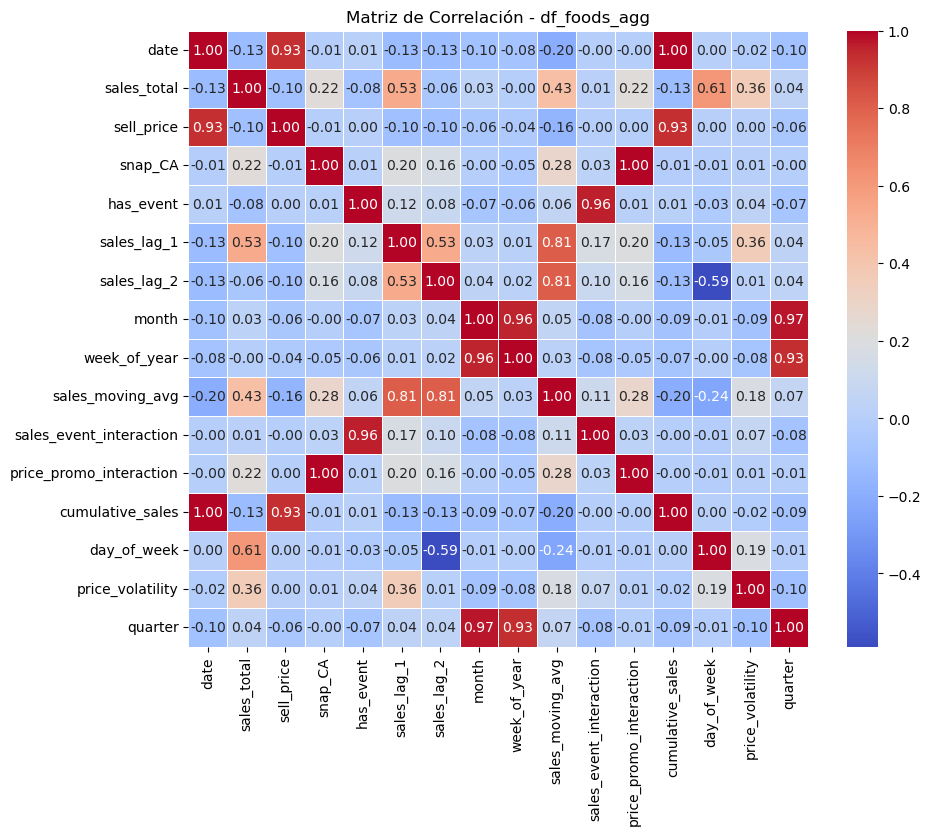

In [86]:
# Crear matriz de correlación
correlation_matrix = df_foods_agg.corr()

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Mostramos el mapa de calor
plt.title('Matriz de Correlación - df_foods_agg')
plt.show()

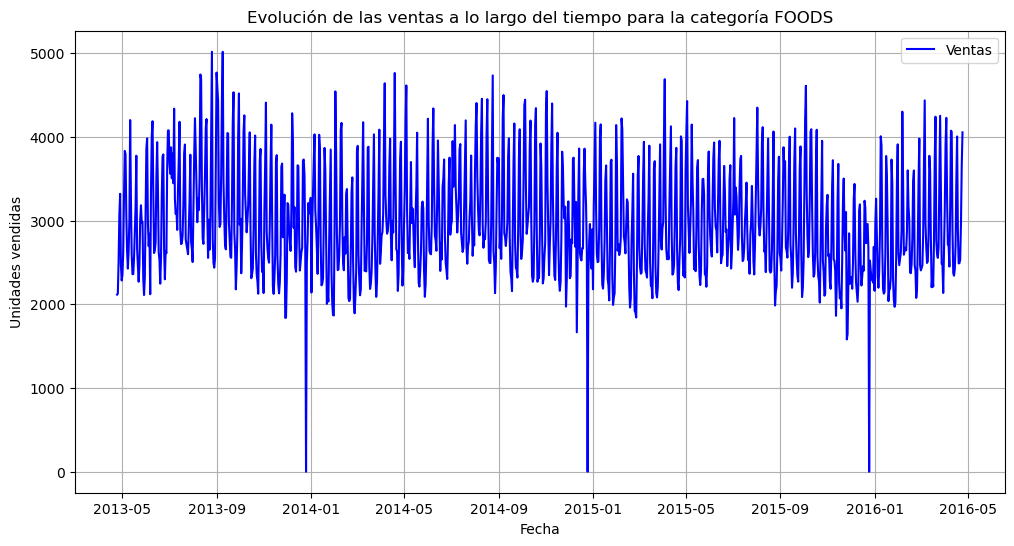

In [87]:
plt.figure(figsize=(12, 6))

# Grafica de ventas diarias
plt.plot(df_foods_agg['date'], df_foods_agg['sales_total'], label='Ventas', color='blue')


plt.title('Evolución de las ventas a lo largo del tiempo para la categoría FOODS')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.show()

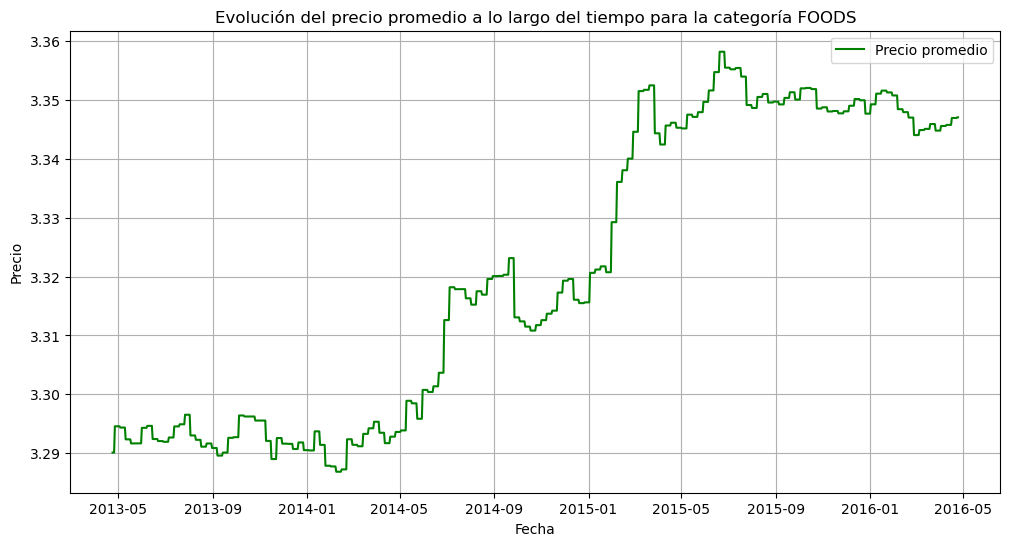

In [88]:
plt.figure(figsize=(12, 6))

# Grafica del precio
plt.plot(df_foods_agg['date'], df_foods_agg['sell_price'], label='Precio promedio', color='green')

plt.title('Evolución del precio promedio a lo largo del tiempo para la categoría FOODS')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

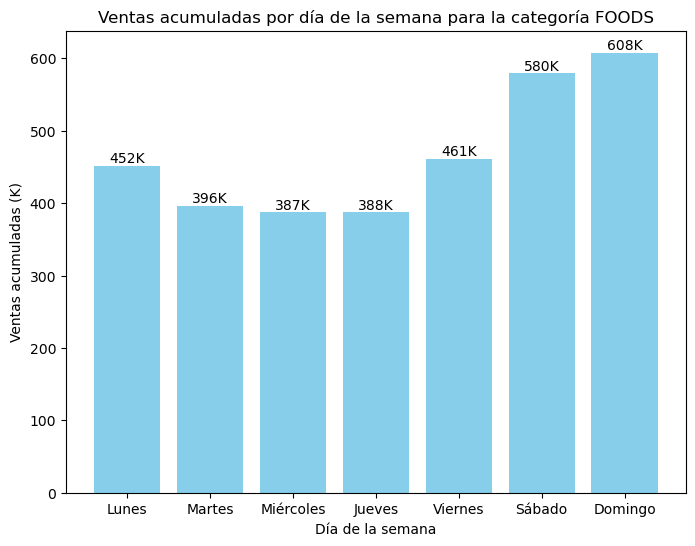

In [89]:
# Agrupamos las ventas por día de la semana
sales_by_day = df_foods_agg.groupby('day_of_week')['sales_total'].sum()

# Definimos los nombres de los días de la semana
days = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

plt.figure(figsize=(8, 6))

# Graficamos las ventas acumuladas por día de la semana
bars = plt.bar(days, sales_by_day / 1000, color='skyblue')  # Dividimos entre 1000 para representar en miles (K)

# Agregamos etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}K', ha='center', va='bottom')

plt.title('Ventas acumuladas por día de la semana para la categoría FOODS')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas acumuladas (K)')
plt.show()

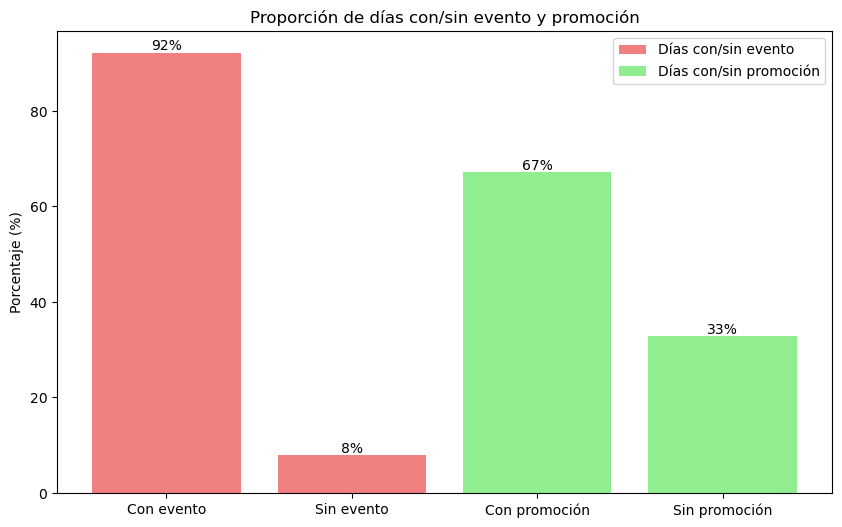

In [90]:
# Contamos los días con evento y sin evento
event_counts = df_foods_agg['has_event'].value_counts(normalize=True) * 100

# Contamos los días con promoción y sin promoción
promo_counts = df_foods_agg['snap_CA'].value_counts(normalize=True) * 100

# Definimos el tamaño de la figura
plt.figure(figsize=(10, 6))

# Creamos el primer gráfico de barras (días con y sin evento)
bars1 = plt.bar(['Con evento', 'Sin evento'], event_counts, label='Días con/sin evento', color='lightcoral')

# Creamos el segundo gráfico de barras (días con y sin promoción)
bars2 = plt.bar(['Con promoción', 'Sin promoción'], promo_counts, label='Días con/sin promoción', color='lightgreen')

# Agregamos etiquetas a las barras (evento)
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%', ha='center', va='bottom')

# Agregamos etiquetas a las barras (promoción)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%', ha='center', va='bottom')

plt.title('Proporción de días con/sin evento y promoción')
plt.ylabel('Porcentaje (%)')
plt.legend()
plt.show()

### Dataset para predicciones a nivel ítem:

In [92]:
df_foods_2_347_agg.head(15)

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2
1,2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2
2,2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2
3,2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2
4,2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2
5,2013-04-29,7,2.0,0,0,9.0,15.0,4,18,8.750000,0,0.0,45,0,0.000000,2
6,2013-04-30,1,2.0,0,0,7.0,9.0,4,18,8.000000,0,0.0,46,1,0.000000,2
7,2013-05-01,10,2.0,1,0,1.0,7.0,5,18,6.750000,0,2.0,56,2,0.000000,2
8,2013-05-02,5,2.0,1,0,10.0,1.0,5,18,5.750000,0,2.0,61,3,0.000000,2
9,2013-05-03,14,2.0,1,0,5.0,10.0,5,18,7.500000,0,2.0,75,4,0.000000,2


In [93]:
df_foods_2_347_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1097 non-null   datetime64[ns]
 1   sales_total              1097 non-null   int64         
 2   sell_price               1097 non-null   float64       
 3   snap_CA                  1097 non-null   int64         
 4   has_event                1097 non-null   int64         
 5   sales_lag_1              1097 non-null   float64       
 6   sales_lag_2              1097 non-null   float64       
 7   month                    1097 non-null   int32         
 8   week_of_year             1097 non-null   UInt32        
 9   sales_moving_avg         1097 non-null   float64       
 10  sales_event_interaction  1097 non-null   int64         
 11  price_promo_interaction  1097 non-null   float64       
 12  cumulative_sales         1097 non-

In [94]:
df_foods_2_347_agg.describe()

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.0,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,2014-10-24 00:00:00,12.118505,2.029535,0.328168,0.078396,12.111212,12.103920,6.519599,26.686418,12.106123,0.797630,0.665087,6772.123063,3.004558,0.000345,2.507748
min,2013-04-24 00:00:00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000
25%,2014-01-23 00:00:00,7.000000,2.000000,0.000000,0.000000,7.000000,7.000000,4.000000,14.0,9.500000,0.000000,0.000000,2987.000000,1.000000,0.000000,2.000000
50%,2014-10-24 00:00:00,11.000000,2.000000,0.000000,0.000000,11.000000,11.000000,7.000000,27.0,12.000000,0.000000,0.000000,6893.000000,3.000000,0.000000,3.000000
75%,2015-07-25 00:00:00,16.000000,2.000000,1.000000,0.000000,16.000000,16.000000,10.000000,40.0,14.500000,0.000000,2.000000,10195.000000,5.000000,0.000000,4.000000
max,2016-04-24 00:00:00,66.000000,2.240000,1.000000,1.000000,66.000000,66.000000,12.000000,53.0,48.750000,35.000000,2.240000,13294.000000,6.000000,0.138564,4.000000
std,NaN,7.571954,0.078878,0.469760,0.268916,7.576883,7.581802,3.449827,15.123281,4.953869,3.325289,0.953029,3966.729793,1.999767,0.006609,1.117293


In [95]:
dfSummary(df_foods_2_347_agg)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,date[datetime64[ns]],"Min: 2013-04-24Max: 2016-04-24Duration: 1,096 days",1097 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABxUlEQVR4nO3XQU7CUBRA0fcbJSCkDSHCAtwBQxbhYl0EK2DgxBEzEtKUUDEarBsAFQeXtN4z/bz+l+amCalpmpAI2bUX0P9hbMLcfHeYUhpERO8Pz80i4rPDc9e4sy1z703THE4dnI0tpTSYTCaPeZ6PL7npeDze1nX9MBqNXrIs++jaXJt2vca72e12ZUrp6VRw333ZenmejxeLxaEoirffXrZer8er1ep+Pp8/z2azsmtzbdqVnquqqr9cLsfb7bYXERfFFhERRVG8TafT199eWJblICJiOBx2cq5Nu17j3UTE4NyBfxCEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhLn56QdVVfUveeB+v+9HRNR13d9sNnddm2vTrvTcT618AcqQOfTDCfo8AAAAAElFTkSuQmCC"">",0(0.0%)
2,sales_total[int64],Mean (sd) : 12.1 (7.6)min < med < max:0.0 < 11.0 < 66.0IQR (CV) : 9.0 (1.6),41 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3dQW7aQBiG4X9KQAZUWwgJdlygUhcsOUQO2213XXACbsAGISEwwo2LMc4qq6YJjKGZz3mf/RgjvQLGwG9XVZUBofvy0ScAXOLhngd3znXNrFPjEMeqqp5udT7QdbdQnXPd4XD4GMfxwPcY+/1+65z7Qay45ytqJ47jwWw2e0qSJL92cZqm0Xw+H2w2m46ZEeond9e3fjOzJEny0Wj023N596YnA1lspiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHh7n+XrqMsy7aZxc45n+VMWWmQYEPNsqxdFMX3yWTSarVaVw+wYMpKswQb6vF4fIiiqDedTvPxeLy9Zi1TVpon2FBf9Pt930krTFlpEDZTkECokECokECokECokPDurr/GePP4fD63PdYBf3kz1DrjzYuiiMqy/Jbn+S8z8x3kC5jZ+6+o3uPNl8vlYLFY9E6nU6vG+QFmduEFf5/x5tvtlgvuuBk2U5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJAQ/N+lfdWcsmLGpJWgNDLUulNWzJi0EppGhlpnyooZk1ZC1MhQX9SYsmLGpJWgsJmCBEKFBEKFBEKFBEKFBEKFBEKFhEZfR62DG12EhVBfwY0uwkOor+BGF+Eh1Df4fgVblmVsfGy4qYtCTdM0uvbAh8MhMjPLsixar9e9/7n+Ix97tVp9rfOxYbfbHZxzP83M61dfwv5UVfXP5/wM3EL5P7vXDVUAAAAASUVORK5CYII="">",0(0.0%)
3,sell_price[float64],1. 2.02. 2.24,962 (87.7%)135 (12.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bQWrDMBhE4V/FhGYjYQw+jA/Rw/YQvo0x1qIJ2aiLrosXGSZBvO8AQosXg4MntdYCcEgRcY2Iy6svgrf1aK3dFAcN0zR95ZxHxWHoT611Tyl9K4Ibcs7jsiy3UspdcTn04ziOz3Vdx23bLhHxfGwREaWU+zzPP0/fDj26qg76UB0EnCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscFmiPj7SO7VF8H7UXcx1Fr3dV3HEH4kh37UWveIeCjOYvCCM7LBS2LKBxf1k032K0B/pFM+5ewL/ZFN+dSzL/RHPeXjjRb/4k9d2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GAjm/IxB8QZ6ZRPOftCfxi8wOYXCltq3zIlI8QAAAAASUVORK5CYII="">",0(0.0%)
4,snap_CA[int64],1. 02. 1,737 (67.2%)360 (32.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bMWrDQBRF0T9BmLiZQQi0GC8ii80iZjdCaIrYuFGKVCFOJ944L/es4BtfBDZ6ad/3ABRSRJwj4tT7EPzqvu/7tfcRRximaXrLOY+9D8FjrbU1pfTuENyQcx4vl8u1lHLrfQy+27bttdY6Lstyioi/H1tERCnlNs/zR+9j8NC59wFHeel9AP4PYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIaIr5f0eh+Cn9y+l6G1ttZaxzB6Sc9Ja22NiHvvO47A4OX52QxeElM+qLg92WyeAo6spnxOszdHNlM+t9mbI7cpH7+onxh/6kKG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGZspn8NncGc15XOavTli8AKZTwpbat8QVM5ZAAAAAElFTkSuQmCC"">",0(0.0%)
5,has_event[int64],1. 02. 1,"1,011 (92.2%)86 (7.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bMWrDQBRF0T9BmLiZQQi0GC0ii80iZjdCaIrYuJkUQU0q/TF6xuKeWsUvLgIbvVBrNUAhmNnVzC6vPgRv6VFrve19uBuG4SvG2B95Ec6plLKEEL73BtfFGPtpmm4

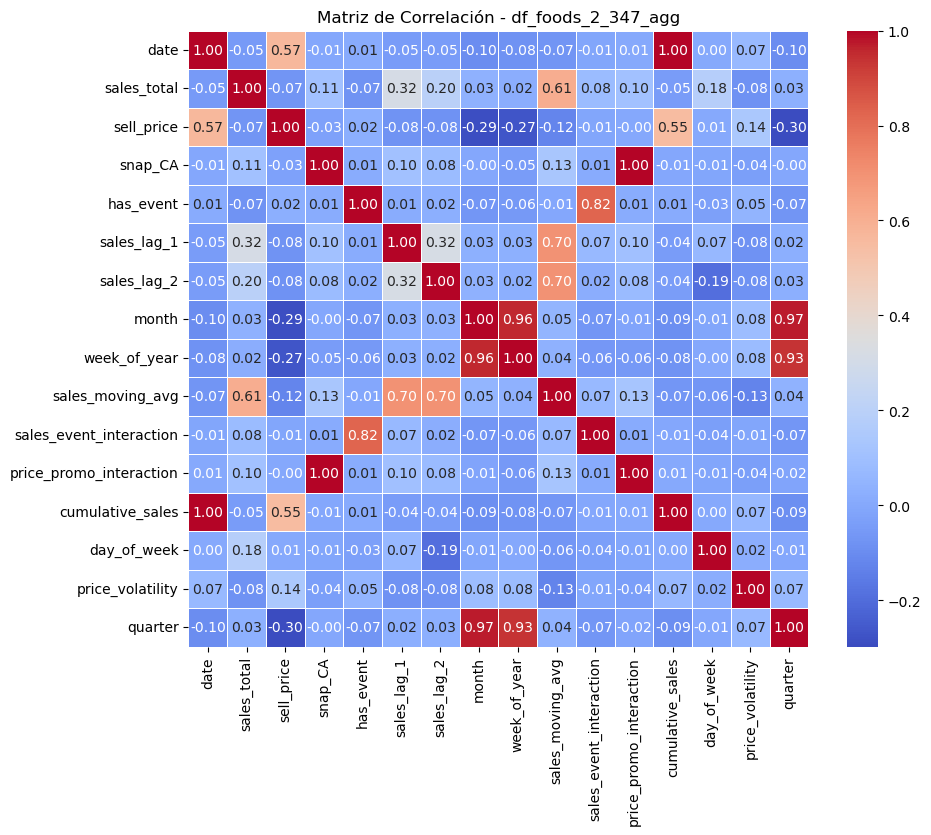

In [96]:
# Calcular la matriz de correlación
correlation_matrix = df_foods_2_347_agg.corr()

# Configuramos el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Creamos el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Mostramos el mapa de calor
plt.title('Matriz de Correlación - df_foods_2_347_agg')
plt.show()

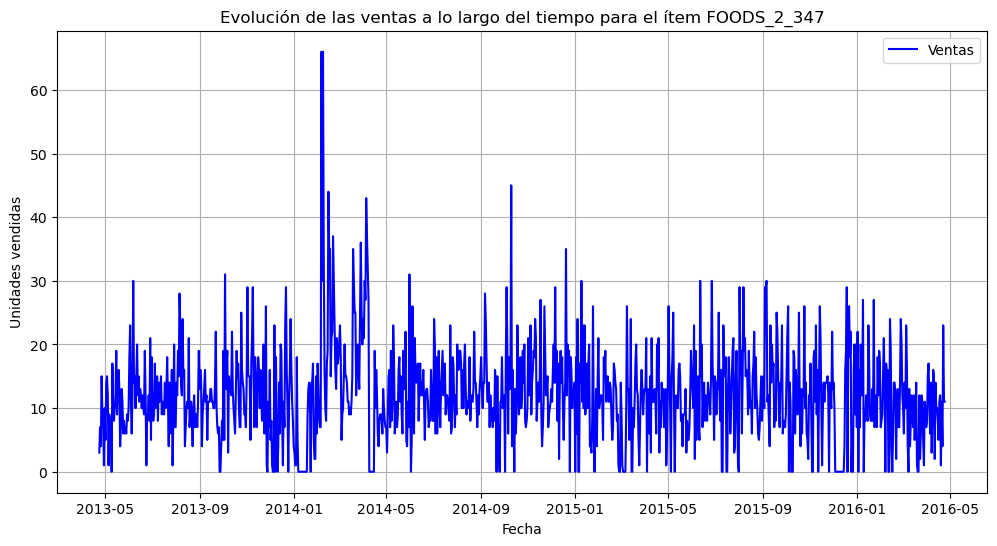

In [97]:
plt.figure(figsize=(12, 6))

# Graficamos ventas diarias
plt.plot(df_foods_2_347_agg['date'], df_foods_2_347_agg['sales_total'], label='Ventas', color='blue')

plt.title('Evolución de las ventas a lo largo del tiempo para el ítem FOODS_2_347')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.show()

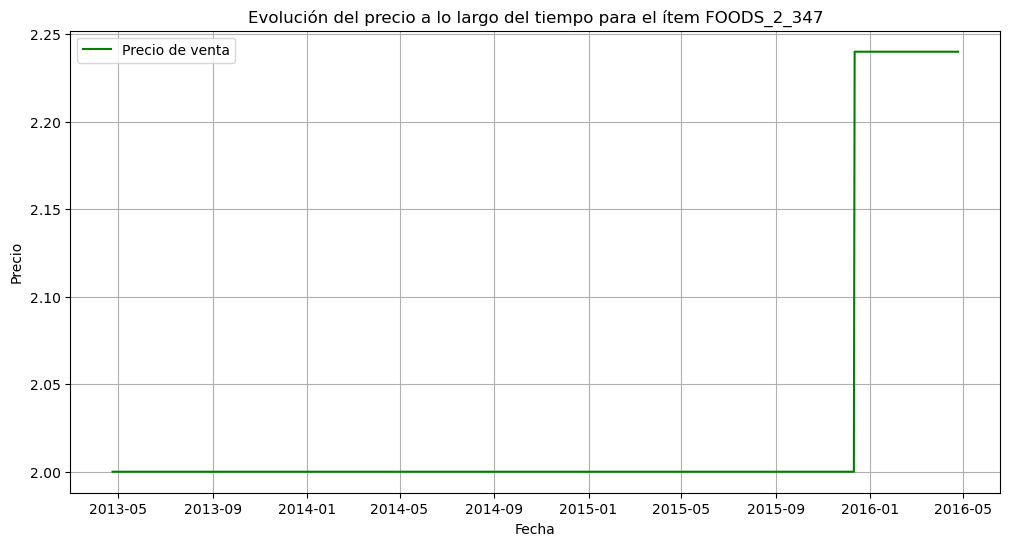

In [98]:
plt.figure(figsize=(12, 6))

# Graficamos el precio de venta
plt.plot(df_foods_2_347_agg['date'], df_foods_2_347_agg['sell_price'], label='Precio de venta', color='green')

plt.title('Evolución del precio a lo largo del tiempo para el ítem FOODS_2_347')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

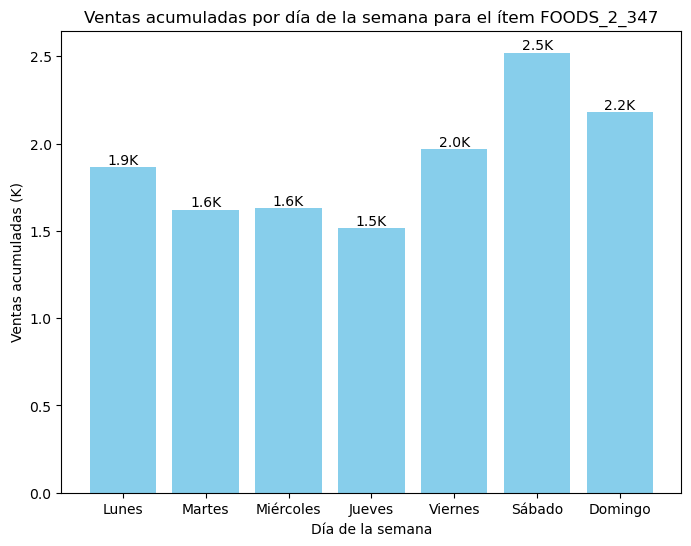

In [99]:
# Agrupamos las ventas por día de la semana
sales_by_day = df_foods_2_347_agg.groupby('day_of_week')['sales_total'].sum()

# Definimos los nombres de los días de la semana
days = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

plt.figure(figsize=(8, 6))

# Graficamos las ventas acumuladas por día de la semana
bars = plt.bar(days, sales_by_day / 1000, color='skyblue')  # Dividimos entre 1000 para representar en miles (K)

# Agregamos etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}K', ha='center', va='bottom')

plt.title('Ventas acumuladas por día de la semana para el ítem FOODS_2_347')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas acumuladas (K)')
plt.show()

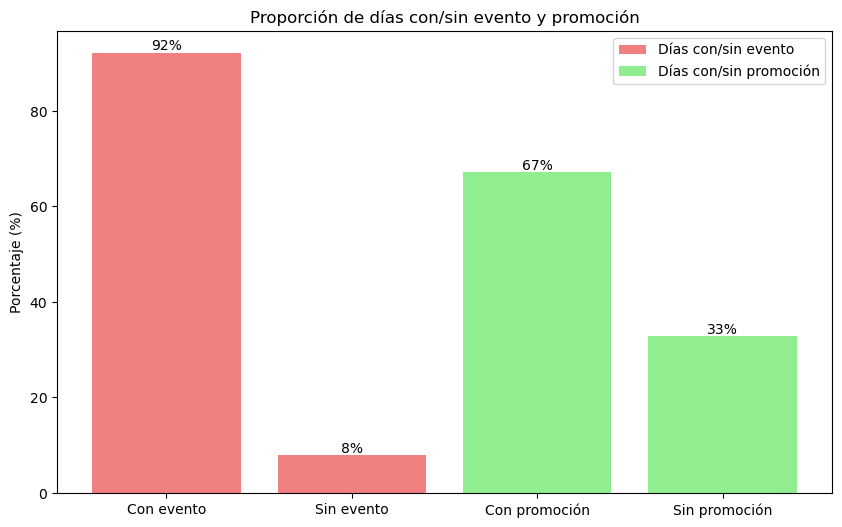

In [100]:
# Contamos los días con evento y sin evento
event_counts = df_foods_2_347_agg['has_event'].value_counts(normalize=True) * 100

# Contamos los días con promoción y sin promoción
promo_counts = df_foods_2_347_agg['snap_CA'].value_counts(normalize=True) * 100

# Definimos el tamaño de la figura
plt.figure(figsize=(10, 6))

# Creamos el primer gráfico de barras (días con y sin evento)
bars1 = plt.bar(['Con evento', 'Sin evento'], event_counts, label='Días con/sin evento', color='lightcoral')

# Creamos el segundo gráfico de barras (días con y sin promoción)
bars2 = plt.bar(['Con promoción', 'Sin promoción'], promo_counts, label='Días con/sin promoción', color='lightgreen')

# Agregamos etiquetas a las barras (evento)
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%', ha='center', va='bottom')

# Agregamos etiquetas a las barras (promoción)
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}%', ha='center', va='bottom')

plt.title('Proporción de días con/sin evento y promoción')
plt.ylabel('Porcentaje (%)')
plt.legend()
plt.show()

## **Aplicar modelos predictivos:**

### **Predicciones a nivel de categoría:**

#### Modelo ARIMA:

In [104]:
# Convertir la columna 'date' a formato datetime y establecerla como índice
df_foods_agg['date'] = pd.to_datetime(df_foods_agg['date'])
df_foods_agg.set_index('date', inplace=True)

In [105]:
df_foods_agg.head()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,,,,,,,,,,,,,,,
2013-04-24,2115,3.290077,0,0,2115.0,2115.0,4,17,2115.0,0,0.0,2115,2,0.000370,2
2013-04-25,2126,3.290077,0,0,2115.0,2115.0,4,17,2120.5,0,0.0,4241,3,0.000000,2
2013-04-26,2506,3.290077,0,0,2126.0,2115.0,4,17,2249.0,0,0.0,6747,4,0.000000,2
2013-04-27,3073,3.294551,0,0,2506.0,2126.0,4,17,2455.0,0,0.0,9820,5,0.002237,2
2013-04-28,3319,3.294551,0,0,3073.0,2506.0,4,17,2756.0,0,0.0,13139,6,0.002583,2


In [106]:
# Definir el periodo de prueba (últimos 365 días)
test_period_days = 365
cutoff_date = df_foods_agg.index[-test_period_days]

# Dividir en conjuntos de entrenamiento y prueba
train_data = df_foods_agg.loc[:cutoff_date, 'sales_total']
test_data = df_foods_agg.loc[cutoff_date:, 'sales_total']

In [107]:
# Definir el rango de valores para p, d, q
p = d = q = range(0, 6)  # Rango de 0 a 5 para cada parámetro

# Generar todas las combinaciones posibles de p, d, q
pdq = list(itertools.product(p, d, q))

# Función para evaluar diferentes modelos ARIMA y devolver el mejor basado en AIC
def optimize_arima(train_data):
    best_aic = float('inf')
    best_pdq = None
    best_model = None
    
    for param in pdq:
        try:
            model = ARIMA(train_data, order=param)
            result = model.fit()
            if result.aic < best_aic:
                best_aic = result.aic
                best_pdq = param
                best_model = result
        except:
            continue
    
    print(f"Mejor modelo ARIMA: Orden {best_pdq} con AIC: {best_aic}")
    return best_model, best_pdq

# Optimizar el modelo ARIMA
best_model, best_pdq = optimize_arima(train_data)

Mejor modelo ARIMA: Orden (5, 0, 5) con AIC: 10697.13423914936


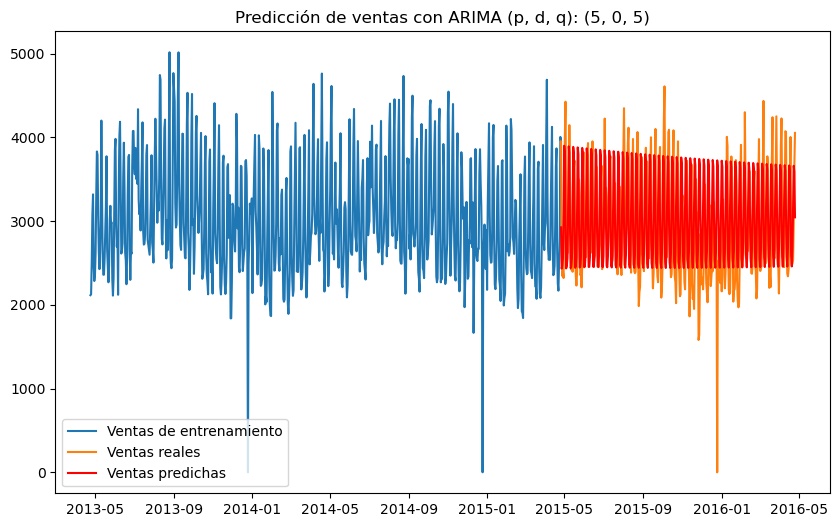

In [192]:
# Predecir las ventas para el periodo de prueba (365 días)
forecast = best_model.forecast(steps=test_period_days)

# Visualizar las predicciones frente a las ventas reales
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Ventas de entrenamiento')
plt.plot(test_data.index, test_data, label='Ventas reales')
plt.plot(test_data.index, forecast, label='Ventas predichas', color='red')
plt.legend()
plt.title(f'Predicción de ventas con ARIMA (p, d, q): {best_pdq}')
plt.show()

In [190]:
#Evaluación de métricas de error
# Calcular MAE y RMSE
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 517.4732062042227
RMSE: 666.7982892240292


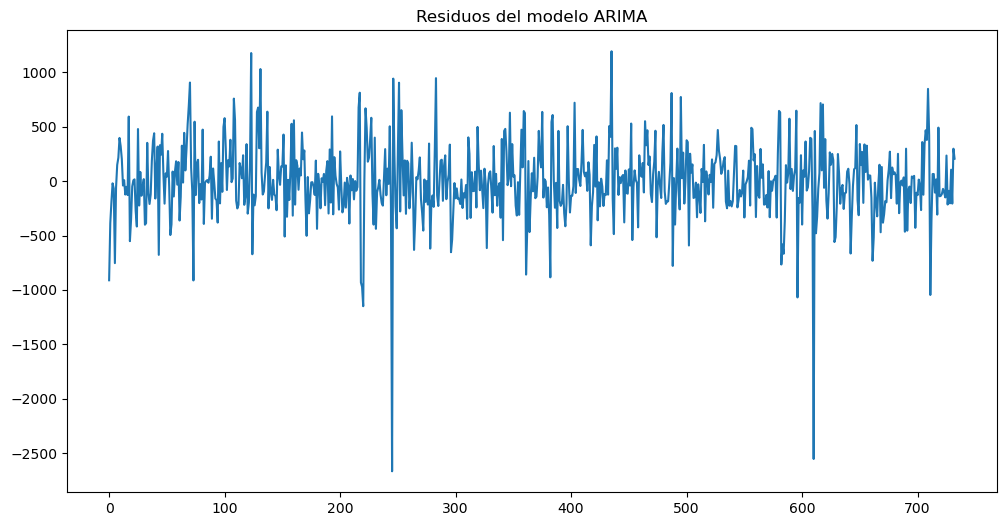

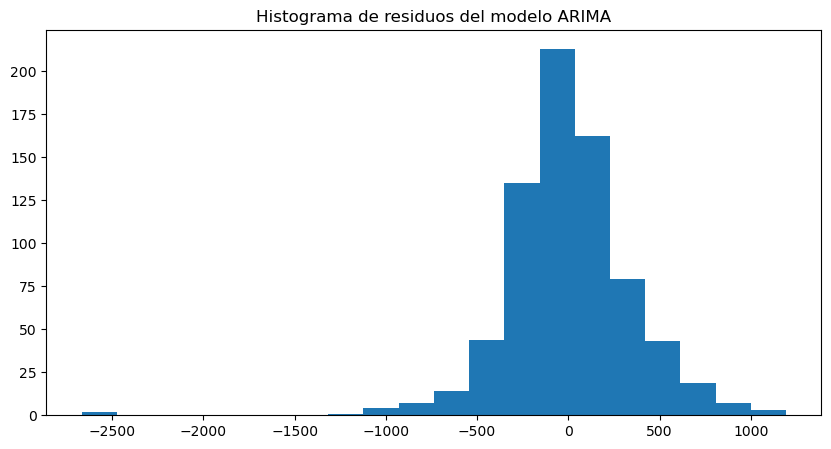

In [109]:
# Obtener los residuos del modelo ARIMA
residuals = best_model.resid

# Graficar los residuos
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuos del modelo ARIMA')
plt.show()

# Graficar el histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.title('Histograma de residuos del modelo ARIMA')
plt.show()

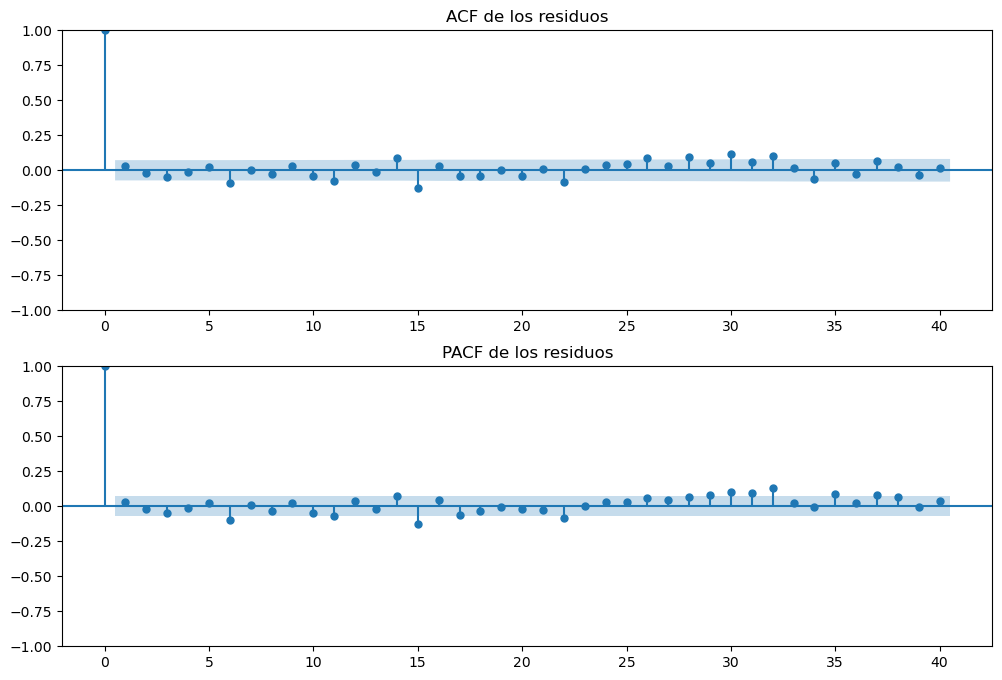

      lb_stat  lb_pvalue
10  12.204260   0.271619
20  39.808222   0.005282


In [110]:
# Graficar la función de autocorrelación de los residuos
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0], title='ACF de los residuos')
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1], title='PACF de los residuos')
plt.show()

# Prueba de Ljung-Box para verificar la autocorrelación en los residuos
ljung_box_result = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print(ljung_box_result)

In [111]:
# Prueba de Dickey-Fuller Aumentada para estacionariedad
adf_test = adfuller(residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Interpretación
if adf_test[1] < 0.05:
    print("Los residuos son estacionarios (se rechaza la hipótesis nula).")
else:
    print("Los residuos no son estacionarios (no se rechaza la hipótesis nula).")

ADF Statistic: -7.556974406164023
p-value: 3.081072498898128e-11
Los residuos son estacionarios (se rechaza la hipótesis nula).


Se reconoce estacionalidad y cierta variabilidad considerable, por lo que se pasa a SARIMA para mejorar los resultados.

#### Modelo SARIMA:

Mejoras:
- Implementar SARIMA para mejorar el reconocimiento de la estacionariedad.
- Aplicar una transformación logarítmica a las ventas para manejar mejor la variabilidad.

In [116]:
# Dividir los datos en train y test (últimos 12 meses para test)
test_size = 365  # Número de días en 12 meses
train, test = df_foods_agg.iloc[:-test_size], df_foods_agg.iloc[-test_size:]

In [117]:
# Manejar valores de cero o negativos (sumar una pequeña constante)
train['sales_total'] = train['sales_total'].replace(0, np.nan)  # Reemplazar ceros por NaN para evitar log(0)
train.fillna(1, inplace=True)  # Reemplazar los NaN por 1 para poder aplicar el logaritmo

# Aplicar la transformación logarítmica a las ventas
train_log = np.log(train['sales_total'])
test_log = np.log(test['sales_total'].replace(0, 1))  # Asegurarse de que no haya ceros en el test

In [118]:
# Optimización más amplia de hiperparámetros SARIMA en los datos transformados
modelo_sarima_log = pm.auto_arima(train_log, 
                                  start_p=1, max_p=5,  # Rango más amplio para p
                                  start_q=1, max_q=5,  # Rango más amplio para q
                                  start_P=0, max_P=3,  # Rango para P estacional
                                  start_Q=0, max_Q=3,  # Rango para Q estacional
                                  d=None,              # Detectar el valor de diferenciación automáticamente
                                  seasonal=True,       # Considerar estacionalidad
                                  m=7,                 # Estacionalidad semanal
                                  trace=True,          # Mostrar el proceso
                                  error_action='ignore',
                                  suppress_warnings=True,
                                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=959.223, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=971.759, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1187.366, Time=0.40 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=941.778, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5121.134, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=957.276, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=930.755, Time=0.14 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=909.861, Time=1.35 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=929.460, Time=1.12 sec
 ARIMA(0,0,1)(1,0,3)[7] intercept   : AIC=974.952, Time=2.42 sec
 ARIMA(0,0,1)(0,0,3)[7] intercept   : AIC=927.896, Time=0.50 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,1)(2,0,3)[7] intercept   : AIC=inf, Time=3.08 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=975.147, Time=1

In [119]:
# Ver los mejores parámetros seleccionados
print(modelo_sarima_log.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  732
Model:             SARIMAX(0, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood                -448.931
Date:                                Mon, 14 Oct 2024   AIC                            909.861
Time:                                        11:20:49   BIC                            937.436
Sample:                                    04-24-2013   HQIC                           920.498
                                         - 04-25-2015                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.002      0.112      0.911      -0.005       0.005
ma.

In [120]:
# Hacer predicciones con SARIMA para los datos log-transformados
n_periods = len(test_log)  # Número de días en el conjunto de prueba (12 meses)
predicciones_log = modelo_sarima_log.predict(n_periods=n_periods)

In [121]:
# Invertir la transformación logarítmica (exponencial) para obtener las predicciones en su escala original
predicciones = np.exp(predicciones_log)

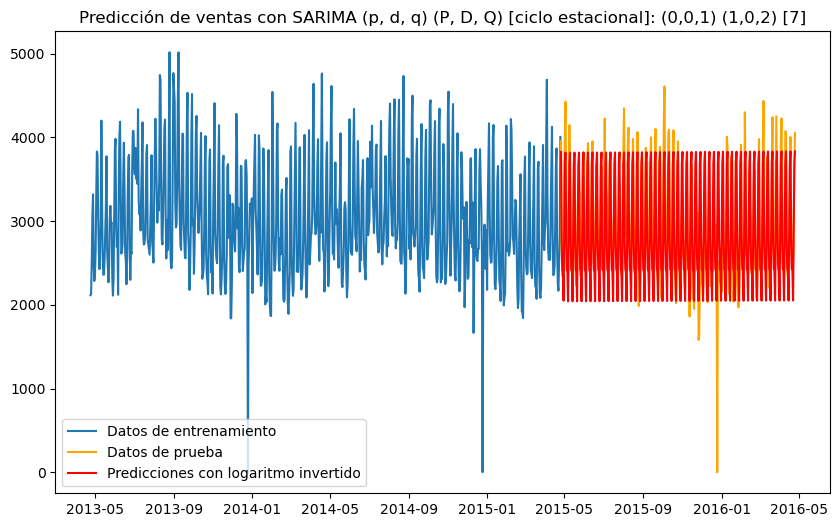

In [122]:
# Graficar los resultados: Datos de entrenamiento, prueba y predicciones
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['sales_total'], label='Datos de entrenamiento')
plt.plot(test.index, test['sales_total'], label='Datos de prueba', color='orange')
plt.plot(test.index, predicciones, label='Predicciones con logaritmo invertido', color='red')
plt.legend()
plt.title('Predicción de ventas con SARIMA (p, d, q) (P, D, Q) [ciclo estacional]: (0,0,1) (1,0,2) [7]')
plt.show()

In [123]:
# Evaluar el rendimiento del modelo con MAE y RMSE
mae = mean_absolute_error(test['sales_total'], predicciones)
rmse = np.sqrt(mean_squared_error(test['sales_total'], predicciones))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 296.8226438798791
RMSE: 404.9956679088094


#### Modelo LightGBM:

In [125]:
df_foods_agg.head()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,,,,,,,,,,,,,,,
2013-04-24,2115,3.290077,0,0,2115.0,2115.0,4,17,2115.0,0,0.0,2115,2,0.000370,2
2013-04-25,2126,3.290077,0,0,2115.0,2115.0,4,17,2120.5,0,0.0,4241,3,0.000000,2
2013-04-26,2506,3.290077,0,0,2126.0,2115.0,4,17,2249.0,0,0.0,6747,4,0.000000,2
2013-04-27,3073,3.294551,0,0,2506.0,2126.0,4,17,2455.0,0,0.0,9820,5,0.002237,2
2013-04-28,3319,3.294551,0,0,3073.0,2506.0,4,17,2756.0,0,0.0,13139,6,0.002583,2


In [126]:
df_foods_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2013-04-24 to 2016-04-24
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sales_total              1097 non-null   int64  
 1   sell_price               1097 non-null   float64
 2   snap_CA                  1097 non-null   int64  
 3   has_event                1097 non-null   int64  
 4   sales_lag_1              1097 non-null   float64
 5   sales_lag_2              1097 non-null   float64
 6   month                    1097 non-null   int32  
 7   week_of_year             1097 non-null   UInt32 
 8   sales_moving_avg         1097 non-null   float64
 9   sales_event_interaction  1097 non-null   int64  
 10  price_promo_interaction  1097 non-null   float64
 11  cumulative_sales         1097 non-null   int64  
 12  day_of_week              1097 non-null   int32  
 13  price_volatility         1097 non-null   float64
 14  quarte

In [127]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_agg.columns.drop(target)

In [128]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [129]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [130]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [131]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}


In [132]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [133]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)


In [134]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [135]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.7, 'reg_lambda': 0.6666666666666666, 'reg_alpha': 0.7777777777777777, 'num_leaves': 140, 'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.23555555555555557, 'colsample_bytree': 1.0}


In [136]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_

In [137]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones = best_model.predict(X_test)

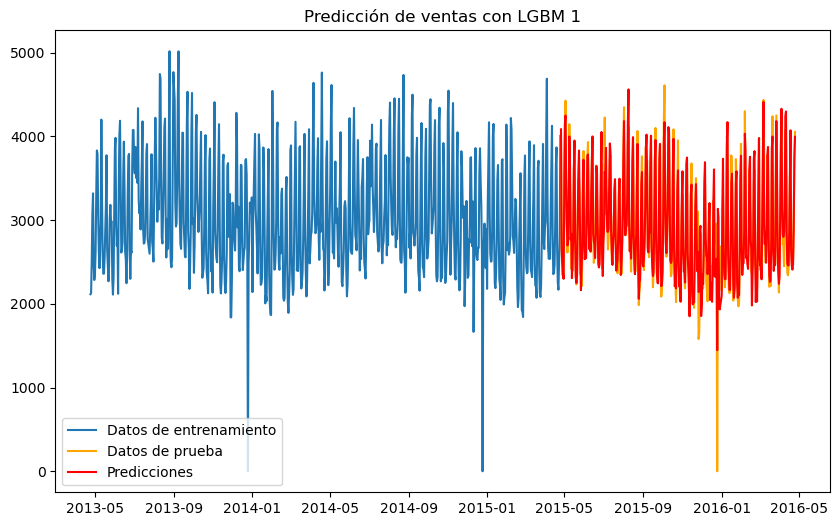

In [138]:
# Graficar los resultados: Datos de entrenamiento, prueba y predicciones
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 1')
plt.legend()
plt.show()

In [139]:
# Paso 10: Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 159.21150956317123
RMSE: 219.56255466995094


                    Feature  Importance
7          sales_moving_avg         441
4               sales_lag_2         356
3               sales_lag_1         312
6              week_of_year         249
0                sell_price         184
10         cumulative_sales         166
12         price_volatility         125
11              day_of_week         109
5                     month          83
9   price_promo_interaction          55
2                 has_event          46
8   sales_event_interaction          44
1                   snap_CA          17
13                  quarter           0


<Figure size 1000x600 with 0 Axes>

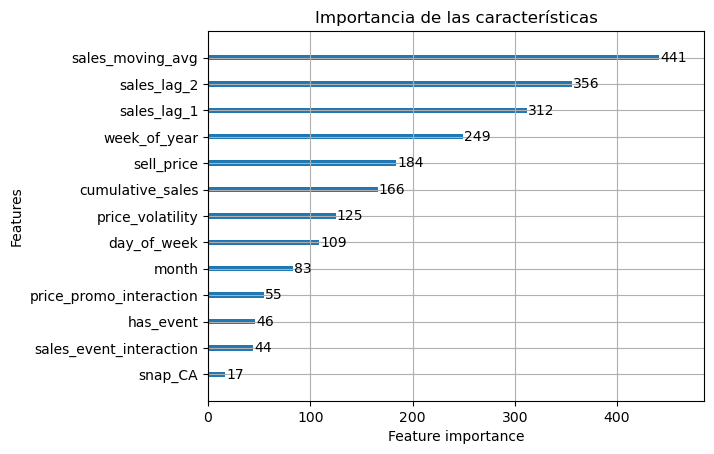

In [140]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_model, max_num_features=20)
plt.title('Importancia de las características')
plt.show()

**Optimización LightGBM:**
- Añadir más características relacionadas con ventas históricas y fechas.
- Escalar variabes con poca variabilidad.


In [142]:
df_foods_agg.describe()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.0,1097.000000,1097.000000,1097.000000,1.097000e+03,1097.000000,1097.000000,1097.000000
mean,2982.558797,3.320516,0.328168,0.078396,2980.792160,2979.388332,6.519599,26.686418,2980.372379,219.041933,1.089627,1.663922e+06,3.004558,0.000370,2.507748
std,664.083350,0.025043,0.469760,0.268916,663.810836,664.012086,3.449827,15.123281,412.314109,783.302678,1.559826,9.463135e+05,1.999767,0.000768,1.117293
min,0.000000,3.286827,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1808.750000,0.000000,0.000000,2.115000e+03,0.000000,0.000000,1.000000
25%,2494.000000,3.293688,0.000000,0.000000,2493.000000,2493.000000,4.000000,14.0,2683.500000,0.000000,0.000000,8.481340e+05,1.000000,0.000000,2.000000
50%,2845.000000,3.317509,0.000000,0.000000,2843.000000,2842.000000,7.000000,27.0,2999.250000,0.000000,0.000000,1.684024e+06,3.000000,0.000000,3.000000
75%,3453.000000,3.347954,1.000000,0.000000,3451.000000,3445.000000,10.000000,40.0,3269.250000,0.000000,3.293848,2.490405e+06,5.000000,0.000410,4.000000
max,5016.000000,3.358232,1.000000,1.000000,5016.000000,5016.000000,12.000000,53.0,4370.000000,4427.000000,3.355518,3.271867e+06,6.000000,0.005818,4.000000


In [143]:
# Crear nuevas características
df_foods_agg['day_of_month'] = df_foods_agg.index.day
df_foods_agg['is_weekend'] = np.where(df_foods_agg.index.weekday >= 5, 1, 0)

# Media móvil ponderada
df_foods_agg['sales_weighted_moving_avg'] = df_foods_agg['sales_total'].rolling(window=7).apply(lambda x: np.average(x, weights=np.arange(1, len(x) + 1)))

# Ventas acumuladas del mes
df_foods_agg['monthly_cumulative_sales'] = df_foods_agg.groupby(df_foods_agg.index.month)['sales_total'].cumsum()

# Ventas con retraso de 7 días (sales_lag_7)
df_foods_agg['sales_lag_7'] = df_foods_agg['sales_total'].shift(7)

In [144]:
# Rellenar valores NaN en sales_weighted_moving_avg y sales_lag_7 con el método 'bfill' (hacia atrás)
df_foods_agg['sales_weighted_moving_avg'].fillna(method='bfill', inplace=True)
df_foods_agg['sales_lag_7'].fillna(method='bfill', inplace=True)

# Verificar si hay valores nulos restantes
print(df_foods_agg.isnull().sum())

sales_total                  0
sell_price                   0
snap_CA                      0
has_event                    0
sales_lag_1                  0
sales_lag_2                  0
month                        0
week_of_year                 0
sales_moving_avg             0
sales_event_interaction      0
price_promo_interaction      0
cumulative_sales             0
day_of_week                  0
price_volatility             0
quarter                      0
day_of_month                 0
is_weekend                   0
sales_weighted_moving_avg    0
monthly_cumulative_sales     0
sales_lag_7                  0
dtype: int64


In [145]:
# Definir las columnas a escalar
columns_to_scale = ['price_volatility', 'price_promo_interaction', 'sales_event_interaction']

# Aplicar escalado MinMax o StandardScaler
scaler = MinMaxScaler()  # Puedes usar StandardScaler() si prefieres
df_foods_agg[columns_to_scale] = scaler.fit_transform(df_foods_agg[columns_to_scale])

In [150]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_agg.columns.drop(target)

In [151]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [152]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [153]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [154]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

In [155]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [156]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)


In [157]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [158]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.8, 'reg_lambda': 0.8888888888888888, 'reg_alpha': 0.1111111111111111, 'num_leaves': 80, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1388888888888889, 'colsample_bytree': 0.9}


In [159]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = lgb.LGBMRegressor(**random_search.best_params_)
best_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.1388888888888889,
              max_depth=4, n_estimators=200, num_leaves=80,
              reg_alpha=0.1111111111111111, reg_lambda=0.8888888888888888,
              subsample=0.8)

In [160]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones_finales = best_model.predict(X_test)

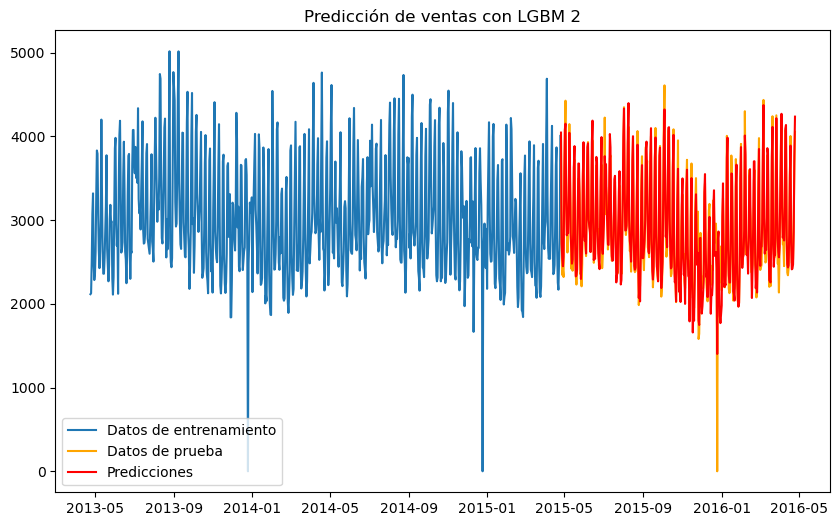

In [161]:
# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones_finales, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 2')
plt.legend()
plt.show()

In [162]:
# Paso 10: Evaluar el rendimiento del modelo
mae_final = mean_absolute_error(y_test, predicciones_finales)
rmse_final = np.sqrt(mean_squared_error(y_test, predicciones_finales))

print(f'MAE final: {mae_final}')
print(f'RMSE final: {rmse_final}')

MAE final: 139.08941522541198
RMSE final: 190.68174489084134


                      Feature  Importance
16  sales_weighted_moving_avg         214
4                 sales_lag_2         162
7            sales_moving_avg         162
3                 sales_lag_1         148
18                sales_lag_7         120
14               day_of_month         107
6                week_of_year         103
11                day_of_week          97
17   monthly_cumulative_sales          77
0                  sell_price          68
12           price_volatility          62
5                       month          52
10           cumulative_sales          50
8     sales_event_interaction          37
2                   has_event          27
9     price_promo_interaction          15
1                     snap_CA           5
13                    quarter           2
15                 is_weekend           1


<Figure size 1000x600 with 0 Axes>

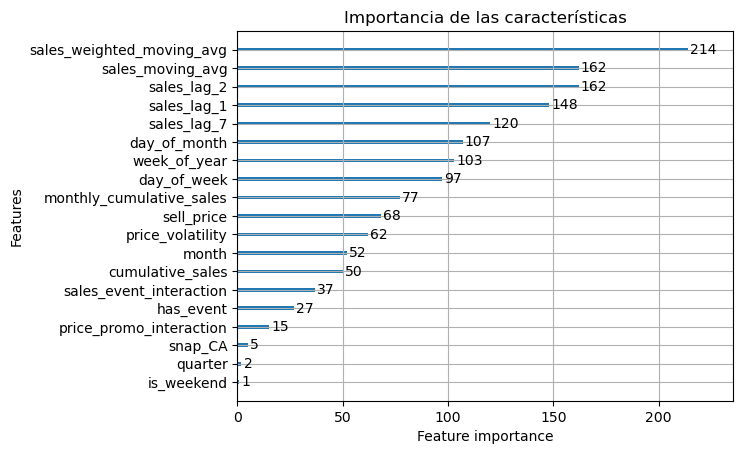

In [163]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
lgb.plot_importance(best_model, max_num_features=20)
plt.title('Importancia de las características')
plt.show()

In [164]:
#Guardar las predicciones en una variable
predicciones = best_model.predict(X_test)

In [165]:
# Validación cruzada de 5 pliegues
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir los resultados a RMSE y mostrar por pliegue
rmse_scores = np.sqrt(-scores)
print(f'RMSE por pliegue: {rmse_scores}')
print(f'RMSE promedio: {rmse_scores.mean()}')

RMSE por pliegue: [249.96515332 261.92473293 223.05664691 177.90475018 240.18008572]
RMSE promedio: 230.60627381088315


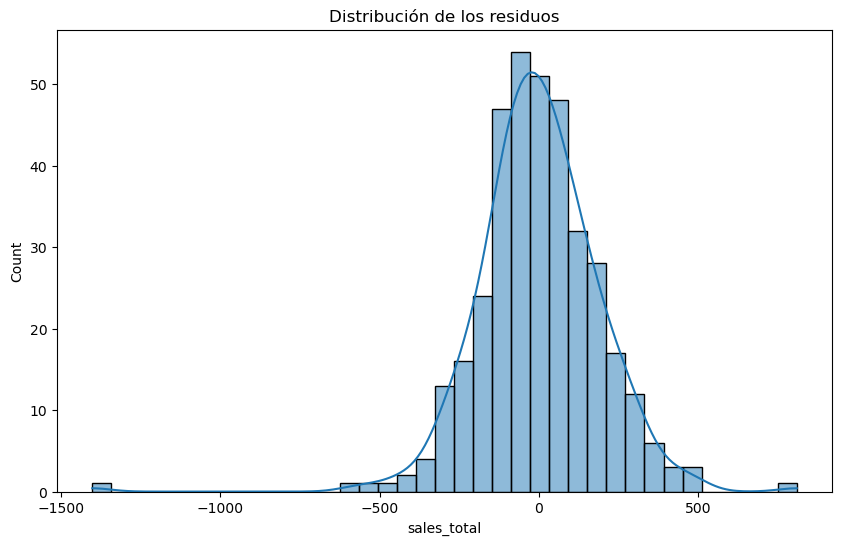

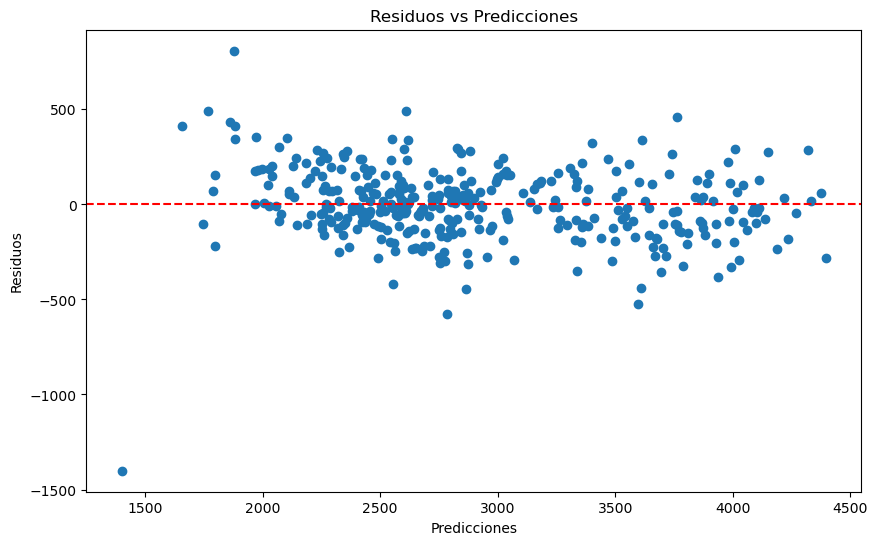

In [166]:
# Calcular los residuos
residuos = y_test - predicciones

# Graficar la distribución de los residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de los residuos')
plt.show()

# Graficar residuos vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(predicciones, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.show()

In [167]:
# Evaluar rendimiento en el conjunto de entrenamiento
train_predicciones = best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_predicciones)
rmse_train = np.sqrt(mean_squared_error(y_train, train_predicciones))

# Evaluar rendimiento en el conjunto de prueba
mae_test = mean_absolute_error(y_test, predicciones)
rmse_test = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'Rendimiento en Entrenamiento - MAE: {mae_train}, RMSE: {rmse_train}')
print(f'Rendimiento en Prueba - MAE: {mae_test}, RMSE: {rmse_test}')

Rendimiento en Entrenamiento - MAE: 70.18398527818007, RMSE: 95.87404358062341
Rendimiento en Prueba - MAE: 139.08941522541198, RMSE: 190.68174489084134


**Post-procesamiento: ajustar el 25 de diciembre con ventas 0 (la tienda cierra ese día)**

In [169]:
# Crear una copia de las predicciones para no alterar las originales, convirtiéndolas a pandas Series con el índice de test
predicciones_ajustadas = pd.Series(predicciones_finales, index=test.index)

# Asegurarse de que las fechas de cierre estén en el conjunto de prueba
# En lugar de usar el índice original, nos basamos en el índice del conjunto de prueba (test)
dias_cierre = test[(test.index.month == 12) & (test.index.day == 25)].index

# Ajustar las predicciones a 0 en esos días específicos
predicciones_ajustadas.loc[dias_cierre] = 0

# Mostrar las predicciones ajustadas para verificar
print(predicciones_ajustadas[dias_cierre])


date
2015-12-25    0.0
dtype: float64


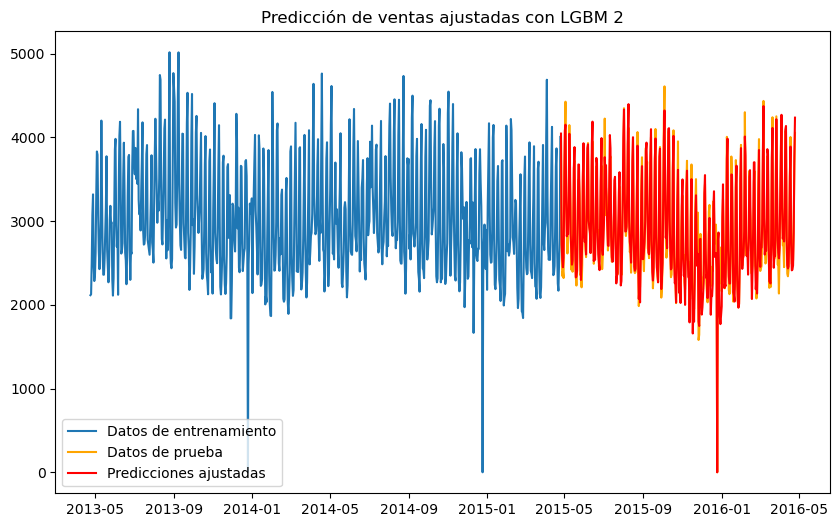

In [170]:
# Graficar los resultados después del ajuste
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones ajustadas
plt.plot(test.index, predicciones_ajustadas, label='Predicciones ajustadas', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas ajustadas con LGBM 2')
plt.legend()
plt.show()

In [171]:
# Calcular el MAE y RMSE para las predicciones ajustadas
mae_ajustado = mean_absolute_error(y_test, predicciones_ajustadas)
rmse_ajustado = np.sqrt(mean_squared_error(y_test, predicciones_ajustadas))

# Mostrar los resultados
print(f'MAE ajustado: {mae_ajustado}')
print(f'RMSE ajustado: {rmse_ajustado}')

MAE ajustado: 135.25097164765145
RMSE ajustado: 176.01632286024835


### **Predicciones a nivel de ítem:**

#### Modelo ARIMA:

In [174]:
df_foods_2_347_agg.head()

,date,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
0,2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2
1,2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2
2,2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2
3,2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2
4,2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2


In [175]:
# Convertir la columna 'date' en un índice de fecha
df_foods_2_347_agg['date'] = pd.to_datetime(df_foods_2_347_agg['date'])
df_foods_2_347_agg.set_index('date', inplace=True)

In [176]:
# Definir el periodo de prueba (últimos 365 días)
test_period_days = 365
cutoff_date = df_foods_2_347_agg.index[-test_period_days]

# Dividir en conjuntos de entrenamiento y prueba
train_data = df_foods_2_347_agg.loc[:cutoff_date, 'sales_total']
test_data = df_foods_2_347_agg.loc[cutoff_date:, 'sales_total']

In [177]:
# Ajustar el modelo ARIMA a los datos de entrenamiento
arima_model = ARIMA(train_data, order=(7, 1, 1))  # Parámetros iniciales (p, d, q)
arima_result = arima_model.fit()

# Imprimir el resumen del modelo
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:            sales_total   No. Observations:                  733
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -2465.692
Date:                Mon, 14 Oct 2024   AIC                           4949.385
Time:                        11:21:55   BIC                           4990.747
Sample:                    04-24-2013   HQIC                          4965.340
                         - 04-26-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2724      0.035      7.736      0.000       0.203       0.341
ar.L2          0.1570      0.023      6.899      0.000       0.112       0.202
ar.L3         -0.0045      0.042     -0.107      0.9

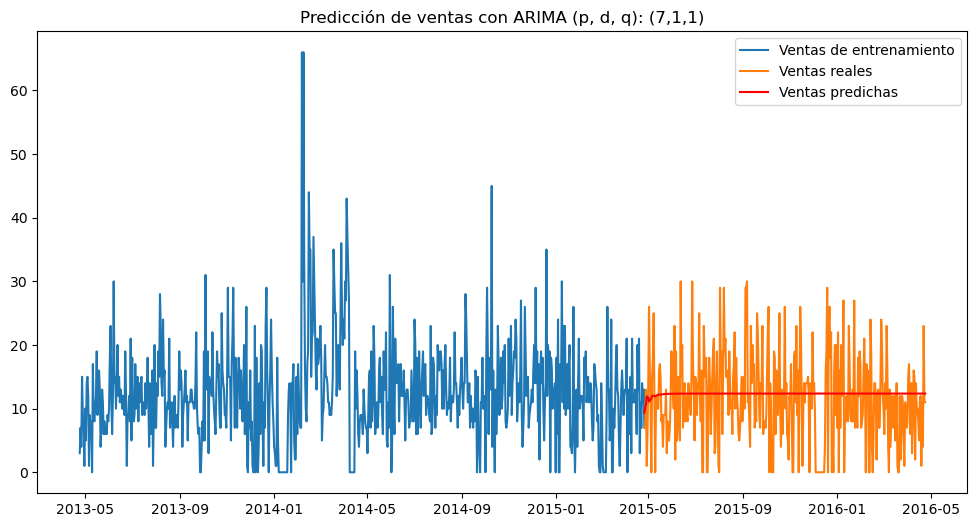

In [178]:
# Predecir las ventas para el periodo de prueba (365 días)
forecast = arima_result.forecast(steps=test_period_days)

# Visualizar las predicciones frente a las ventas reales
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Ventas de entrenamiento')
plt.plot(test_data.index, test_data, label='Ventas reales')
plt.plot(test_data.index, forecast, label='Ventas predichas', color='red')
plt.legend()
plt.title('Predicción de ventas con ARIMA (p, d, q): (7,1,1)')
plt.show()

In [179]:
# Calcular MAE y RMSE
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 5.720807170344412
RMSE: 7.180233744860556


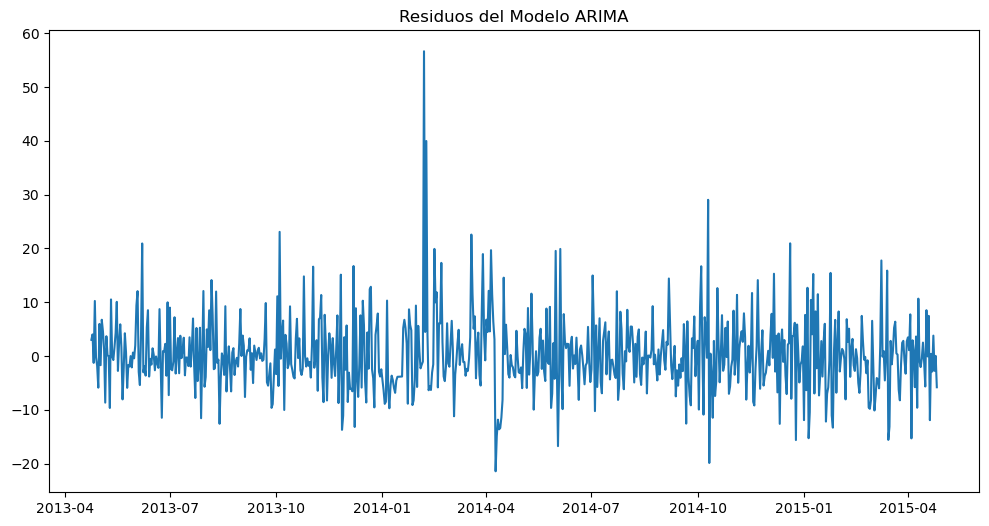

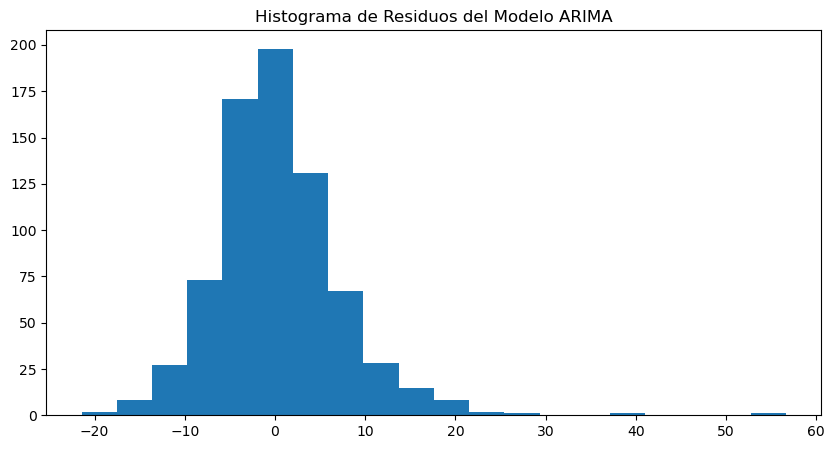

In [180]:
# Obtener los residuos del modelo ARIMA
residuals = arima_result.resid

# Graficar los residuos
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuos del Modelo ARIMA')
plt.show()

# Graficar el histograma de los residuos
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20)
plt.title('Histograma de Residuos del Modelo ARIMA')
plt.show()

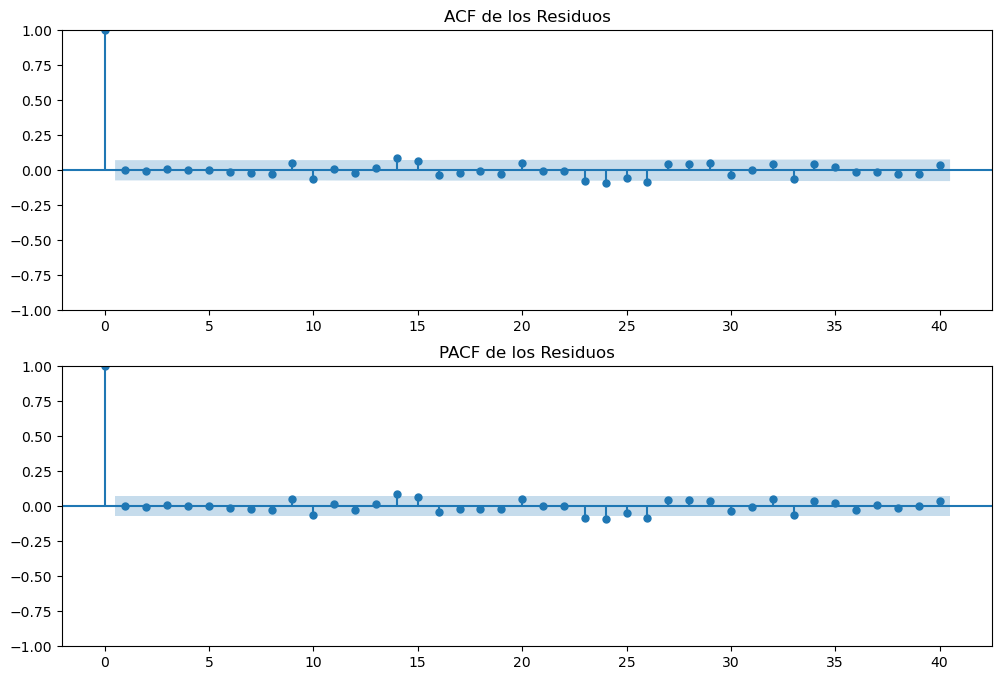

      lb_stat  lb_pvalue
10   5.773146   0.833949
20  19.175332   0.510457


In [181]:
# Graficar la función de autocorrelación de los residuos
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax[0], title='ACF de los Residuos')
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax[1], title='PACF de los Residuos')
plt.show()

# Prueba de Ljung-Box para verificar la autocorrelación en los residuos
ljung_box_result = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print(ljung_box_result)

In [182]:
# Prueba de Dickey-Fuller Aumentada para estacionariedad
adf_test = adfuller(residuals)
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Interpretación
if adf_test[1] < 0.05:
    print("Los residuos son estacionarios (se rechaza la hipótesis nula).")
else:
    print("Los residuos no son estacionarios (no se rechaza la hipótesis nula).")

ADF Statistic: -26.996778596844354
p-value: 0.0
Los residuos son estacionarios (se rechaza la hipótesis nula).


Se reconoce estacionalidad y cierta variabilidad considerable, por lo que se pasa a SARIMA para mejorar los resultados.

#### Modelo SARIMA:

In [185]:
# Definir el conjunto de entrenamiento y test (últimos 365 días)
train_data = df_foods_2_347_agg[:-365]
test_data = df_foods_2_347_agg[-365:]

In [186]:
# Definir el modelo SARIMA con un período estacional de 7 días (semanal)
model_sarima = SARIMAX(train_data['sales_total'],
                       order=(1, 1, 1),  # p, d, q
                       seasonal_order=(1, 1, 1, 7))  # P, D, Q, m (m=7 para estacionalidad semanal)

# Ajustar el modelo
sarima_model = model_sarima.fit()

# Mostrar el resumen del modelo ajustado
print(sarima_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.51720D+00    |proj g|=  7.97573D-02



 This problem is unconstrained.


At iterate    5    f=  3.35511D+00    |proj g|=  6.87579D-02

At iterate   10    f=  3.34333D+00    |proj g|=  6.99229D-03

At iterate   15    f=  3.34196D+00    |proj g|=  9.81595D-03

At iterate   20    f=  3.34139D+00    |proj g|=  2.04522D-03

At iterate   25    f=  3.34132D+00    |proj g|=  9.54821D-04

At iterate   30    f=  3.34131D+00    |proj g|=  6.95080D-04

At iterate   35    f=  3.34131D+00    |proj g|=  2.48230D-04

At iterate   40    f=  3.34131D+00    |proj g|=  3.83412D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     45      1     0     0   3.834D-05   3.341D+00
  F =   3.341311125773

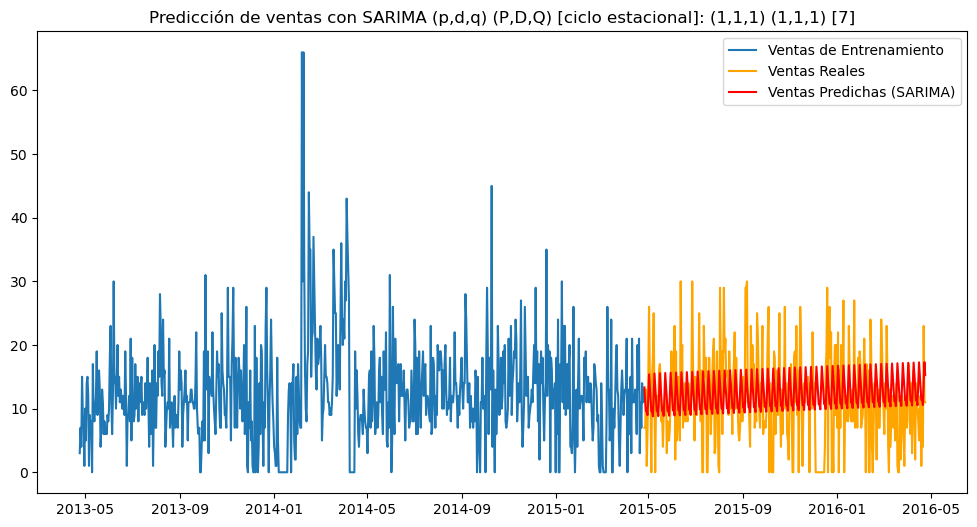

In [187]:
# Realizar las predicciones para el período de prueba
sarima_forecast = sarima_model.forecast(steps=365)

# Visualizar las predicciones frente a las ventas reales y las de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['sales_total'], label='Ventas de Entrenamiento')
plt.plot(test_data.index, test_data['sales_total'], label='Ventas Reales', color='orange')
plt.plot(test_data.index, sarima_forecast, label='Ventas Predichas (SARIMA)', color='red')
plt.legend()
plt.title('Predicción de ventas con SARIMA (p,d,q) (P,D,Q) [ciclo estacional]: (1,1,1) (1,1,1) [7]')
plt.show()

In [188]:
# Calcular MAE y RMSE
sarima_mae = mean_absolute_error(test_data['sales_total'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data['sales_total'], sarima_forecast))

print(f"MAE: {sarima_mae}")
print(f"RMSE: {sarima_rmse}")

MAE: 5.625151129669595
RMSE: 7.04145675826171


**Optimizar SARIMA:**
- Busqueda optimizada automática.

In [190]:
# Definir el conjunto de entrenamiento y test (últimos 365 días)
train_data = df_foods_2_347_agg[:-365]
test_data = df_foods_2_347_agg[-365:]

In [191]:
# Ajustar auto_arima para buscar el mejor modelo SARIMA
auto_sarima_model = auto_arima(train_data['sales_total'],
                               seasonal=True, m=7,  # m=7 para estacionalidad semanal
                               trace=True, suppress_warnings=True)

# Ajustar el mejor modelo SARIMA
auto_sarima_model.fit(train_data['sales_total'])

# Predecir con el mejor modelo
auto_sarima_forecast = auto_sarima_model.predict(n_periods=365)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4934.420, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5080.633, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=4962.254, Time=0.10 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=4989.021, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=6011.107, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4955.532, Time=0.50 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=4951.535, Time=0.49 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=4947.345, Time=1.23 sec
 ARIMA(2,0,2)(2,0,0)[7] intercept   : AIC=4945.664, Time=1.11 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=4952.986, Time=1.66 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=4940.634, Time=0.62 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=4939.4

In [192]:
# Mostrar el resumen del modelo optimizado
print(auto_sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  732
Model:             SARIMAX(3, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -2453.317
Date:                           Mon, 14 Oct 2024   AIC                           4922.634
Time:                                   11:22:33   BIC                           4959.401
Sample:                               04-24-2013   HQIC                          4936.817
                                    - 04-25-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3033      0.201      1.510      0.131      -0.090       0.697
ar.L1         -0.7002      0.035    -20.208

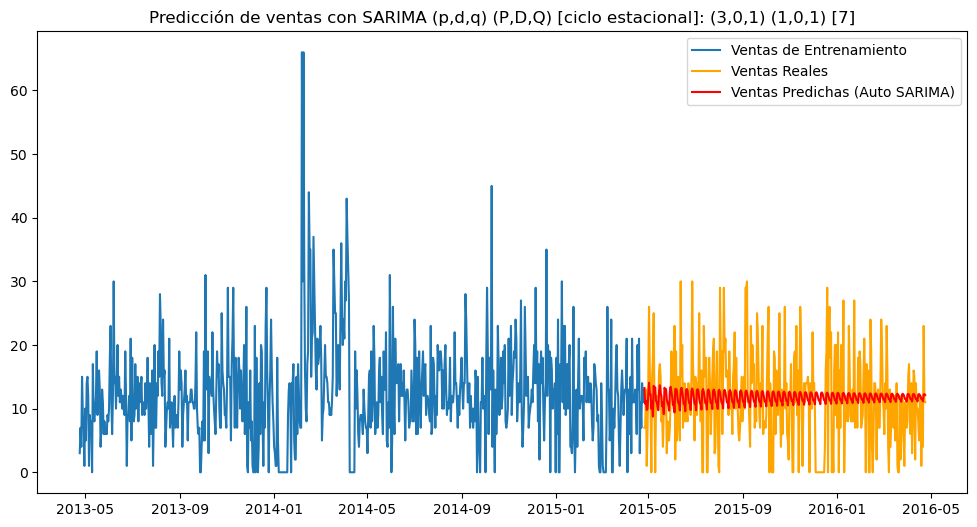

In [193]:
# Visualización
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['sales_total'], label='Ventas de Entrenamiento')
plt.plot(test_data.index, test_data['sales_total'], label='Ventas Reales', color='orange')
plt.plot(test_data.index, auto_sarima_forecast, label='Ventas Predichas (Auto SARIMA)', color='red')
plt.legend()
plt.title('Predicción de ventas con SARIMA (p,d,q) (P,D,Q) [ciclo estacional]: (3,0,1) (1,0,1) [7]')
plt.show()

In [194]:
# Calcular MAE y RMSE
sarima_mae = mean_absolute_error(test_data['sales_total'], auto_sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data['sales_total'], auto_sarima_forecast))

print(f"MAE: {sarima_mae}")
print(f"RMSE: {sarima_rmse}")

MAE: 5.550895121886274
RMSE: 6.994543393269889


#### Modelo LightGBM:

In [196]:
df_foods_2_347_agg.head()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,,,,,,,,,,,,,,,
2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2
2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2
2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2
2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2
2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2


In [197]:
X = df_foods_2_347_agg.drop(columns=['sales_total'])  # Eliminamos solo la columna 'sales_total' como objetivo
y = df_foods_2_347_agg['sales_total']  # Definimos la variable objetivo

# Dividir los datos en entrenamiento (todo menos los últimos 365 días) y prueba (los últimos 365 días)
X_train, X_test = X[:-365], X[-365:]
y_train, y_test = y[:-365], y[-365:]

In [198]:
# Definir el modelo LightGBM
model = LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'num_leaves': [31, 40, 50, 60],          # Diferentes valores para el número de hojas
    'max_depth': [-1, 10, 20, 30],           # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1],      # Tasas de aprendizaje
    'n_estimators': [100, 200, 500],         # Número de estimadores
    'min_child_samples': [10, 20, 30],       # Mínimo de muestras en una hoja
    'subsample': [0.8, 1.0],                 # Proporción de muestras a usar en cada iteración
    'colsample_bytree': [0.8, 1.0]           # Proporción de características a usar
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=50, cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

# Ajustar el modelo al conjunto de entrenamiento
random_search.fit(X_train, y_train)

# Imprimir los mejores parámetros
print(f'Mejores hiperparámetros: {random_search.best_params_}')

# Predecir con el mejor modelo
y_pred_opt = random_search.best_estimator_.predict(X_test)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Mejores hiperparámetros: {'subsample': 1.0, 'num_leaves': 60, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [199]:
# Imprimir los mejores parámetros
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 1.0, 'num_leaves': 60, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


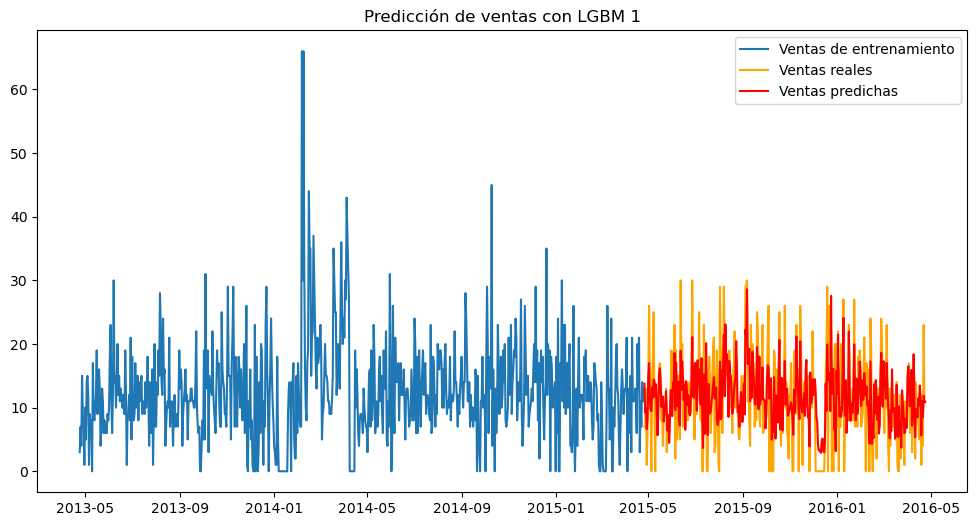

In [200]:
# Graficar las ventas de entrenamiento, las ventas reales y las predicciones del modelo optimizado
plt.figure(figsize=(12, 6))

# Graficar las ventas de entrenamiento
plt.plot(y_train.index, y_train.values, label='Ventas de entrenamiento')

# Graficar las ventas reales
plt.plot(y_test.index, y_test.values, label='Ventas reales', color='orange')

# Graficar las ventas predichas por el modelo optimizado LightGBM
plt.plot(y_test.index, y_pred_opt, label='Ventas predichas', color='red')

# Añadir leyenda y título
plt.legend()
plt.title('Predicción de ventas con LGBM 1')

# Mostrar la gráfica
plt.show()

In [201]:
# Calcular MAE y RMSE
mae = mean_absolute_error(y_test, y_pred_opt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_opt))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 4.214123817450026
RMSE: 5.334195840897277


                    Feature  Importance
7          sales_moving_avg         900
10         cumulative_sales         682
3               sales_lag_1         652
4               sales_lag_2         617
6              week_of_year         415
11              day_of_week         389
5                     month         295
1                   snap_CA          90
8   sales_event_interaction          46
9   price_promo_interaction          31
2                 has_event          26
13                  quarter          10
0                sell_price           0
12         price_volatility           0


<Figure size 1000x600 with 0 Axes>

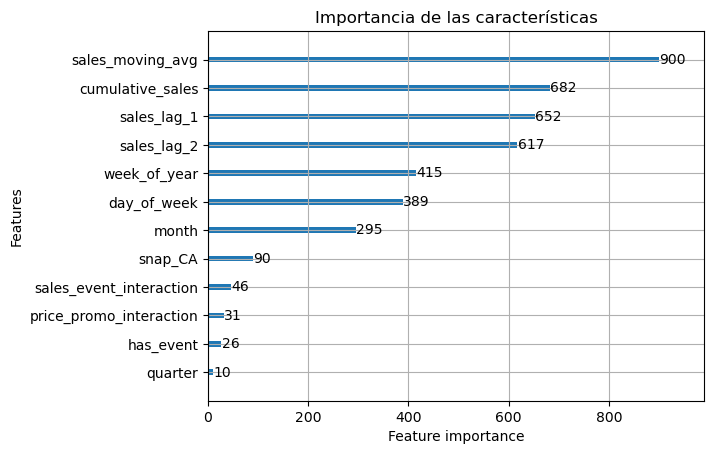

In [202]:
# Obtener la importancia de las características
importance = random_search.best_estimator_.feature_importances_
features = X_train.columns

# Crear un dataframe con la importancia de cada característica
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Ordenar las características por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print(feature_importance_df)



# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
lgb.plot_importance(random_search.best_estimator_, max_num_features=20)
plt.title('Importancia de las características')
plt.show()

**Optimización:**
- Agregar variables relevantes.

In [204]:
df_foods_2_347_agg.head()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,,,,,,,,,,,,,,,
2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2
2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2
2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2
2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2
2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2


In [205]:
df_foods_2_347_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2013-04-24 to 2016-04-24
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   sales_total              1097 non-null   int64  
 1   sell_price               1097 non-null   float64
 2   snap_CA                  1097 non-null   int64  
 3   has_event                1097 non-null   int64  
 4   sales_lag_1              1097 non-null   float64
 5   sales_lag_2              1097 non-null   float64
 6   month                    1097 non-null   int32  
 7   week_of_year             1097 non-null   UInt32 
 8   sales_moving_avg         1097 non-null   float64
 9   sales_event_interaction  1097 non-null   int64  
 10  price_promo_interaction  1097 non-null   float64
 11  cumulative_sales         1097 non-null   int64  
 12  day_of_week              1097 non-null   int32  
 13  price_volatility         1097 non-null   float64
 14  quarte

In [206]:
df_foods_2_347_agg.describe()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.0,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,12.118505,2.029535,0.328168,0.078396,12.111212,12.103920,6.519599,26.686418,12.106123,0.797630,0.665087,6772.123063,3.004558,0.000345,2.507748
std,7.571954,0.078878,0.469760,0.268916,7.576883,7.581802,3.449827,15.123281,4.953869,3.325289,0.953029,3966.729793,1.999767,0.006609,1.117293
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000
25%,7.000000,2.000000,0.000000,0.000000,7.000000,7.000000,4.000000,14.0,9.500000,0.000000,0.000000,2987.000000,1.000000,0.000000,2.000000
50%,11.000000,2.000000,0.000000,0.000000,11.000000,11.000000,7.000000,27.0,12.000000,0.000000,0.000000,6893.000000,3.000000,0.000000,3.000000
75%,16.000000,2.000000,1.000000,0.000000,16.000000,16.000000,10.000000,40.0,14.500000,0.000000,2.000000,10195.000000,5.000000,0.000000,4.000000
max,66.000000,2.240000,1.000000,1.000000,66.000000,66.000000,12.000000,53.0,48.750000,35.000000,2.240000,13294.000000,6.000000,0.138564,4.000000


In [207]:
# Crear la nueva característica 'day_of_month'
df_foods_2_347_agg['day_of_month'] = df_foods_2_347_agg.index.day

# Crear la nueva característica 'is_weekend' (1 si es fin de semana, 0 si no lo es)
df_foods_2_347_agg['is_weekend'] = df_foods_2_347_agg.index.dayofweek.isin([5, 6]).astype(int)

# Crear 'sales_weighted_moving_avg' como un promedio ponderado móvil de las ventas
df_foods_2_347_agg['sales_weighted_moving_avg'] = df_foods_2_347_agg['sales_total'].ewm(span=7, adjust=False).mean()

# Crear 'monthly_cumulative_sales' como la suma acumulativa de ventas por mes
df_foods_2_347_agg['monthly_cumulative_sales'] = df_foods_2_347_agg['sales_total'].groupby(df_foods_2_347_agg.index.to_period('M')).cumsum()

# Crear 'sales_lag_7' como las ventas con un rezago de 7 días
df_foods_2_347_agg['sales_lag_7'] = df_foods_2_347_agg['sales_total'].shift(7)

# Rellenar valores NaN con el método 'bfill' (hacia atrás)
df_foods_2_347_agg['sales_weighted_moving_avg'].fillna(method='bfill', inplace=True)
df_foods_2_347_agg['sales_lag_7'].fillna(method='bfill', inplace=True)

In [208]:
# Verificar si hay valores nulos restantes
print(df_foods_agg.isnull().sum())

sales_total                  0
sell_price                   0
snap_CA                      0
has_event                    0
sales_lag_1                  0
sales_lag_2                  0
month                        0
week_of_year                 0
sales_moving_avg             0
sales_event_interaction      0
price_promo_interaction      0
cumulative_sales             0
day_of_week                  0
price_volatility             0
quarter                      0
day_of_month                 0
is_weekend                   0
sales_weighted_moving_avg    0
monthly_cumulative_sales     0
sales_lag_7                  0
dtype: int64


In [209]:
df_foods_2_347_agg.head()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
date,,,,,,,,,,,,,,,,,,,,
2013-04-24,3,2.0,0,0,3.0,3.0,4,17,3.000000,0,0.0,3,2,0.000345,2,24,0,3.0000,3,3.0
2013-04-25,7,2.0,0,0,3.0,3.0,4,17,5.000000,0,0.0,10,3,0.000000,2,25,0,4.0000,10,3.0
2013-04-26,4,2.0,0,0,7.0,3.0,4,17,4.666667,0,0.0,14,4,0.000000,2,26,0,4.0000,14,3.0
2013-04-27,15,2.0,0,0,4.0,7.0,4,17,7.250000,0,0.0,29,5,0.000000,2,27,1,6.7500,29,3.0
2013-04-28,9,2.0,0,0,15.0,4.0,4,17,8.750000,0,0.0,38,6,0.000000,2,28,1,7.3125,38,3.0


In [210]:
df_foods_2_347_agg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1097 entries, 2013-04-24 to 2016-04-24
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales_total                1097 non-null   int64  
 1   sell_price                 1097 non-null   float64
 2   snap_CA                    1097 non-null   int64  
 3   has_event                  1097 non-null   int64  
 4   sales_lag_1                1097 non-null   float64
 5   sales_lag_2                1097 non-null   float64
 6   month                      1097 non-null   int32  
 7   week_of_year               1097 non-null   UInt32 
 8   sales_moving_avg           1097 non-null   float64
 9   sales_event_interaction    1097 non-null   int64  
 10  price_promo_interaction    1097 non-null   float64
 11  cumulative_sales           1097 non-null   int64  
 12  day_of_week                1097 non-null   int32  
 13  price_volatility           109

In [211]:
df_foods_2_347_agg.describe()

,sales_total,sell_price,snap_CA,has_event,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,sales_event_interaction,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
count,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.0,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,12.118505,2.029535,0.328168,0.078396,12.111212,12.103920,6.519599,26.686418,12.106123,0.797630,0.665087,6772.123063,3.004558,0.000345,2.507748,15.740201,0.286235,12.096213,194.756609,12.071103
std,7.571954,0.078878,0.469760,0.268916,7.576883,7.581802,3.449827,15.123281,4.953869,3.325289,0.953029,3966.729793,1.999767,0.006609,1.117293,8.804909,0.452207,4.095516,120.772000,7.588075
min,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.241134,0.000000,0.000000
25%,7.000000,2.000000,0.000000,0.000000,7.000000,7.000000,4.000000,14.0,9.500000,0.000000,0.000000,2987.000000,1.000000,0.000000,2.000000,8.000000,0.000000,10.023088,91.000000,7.000000
50%,11.000000,2.000000,0.000000,0.000000,11.000000,11.000000,7.000000,27.0,12.000000,0.000000,0.000000,6893.000000,3.000000,0.000000,3.000000,16.000000,0.000000,11.805367,194.000000,11.000000
75%,16.000000,2.000000,1.000000,0.000000,16.000000,16.000000,10.000000,40.0,14.500000,0.000000,2.000000,10195.000000,5.000000,0.000000,4.000000,23.000000,1.000000,13.876289,286.000000,16.000000
max,66.000000,2.240000,1.000000,1.000000,66.000000,66.000000,12.000000,53.0,48.750000,35.000000,2.240000,13294.000000,6.000000,0.138564,4.000000,31.000000,1.000000,35.113032,663.000000,66.000000


In [212]:
dfSummary(df_foods_2_347_agg)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,sales_total[int64],Mean (sd) : 12.1 (7.6)min < med < max:0.0 < 11.0 < 66.0IQR (CV) : 9.0 (1.6),41 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3dQW7aQBiG4X9KQAZUWwgJdlygUhcsOUQO2213XXACbsAGISEwwo2LMc4qq6YJjKGZz3mf/RgjvQLGwG9XVZUBofvy0ScAXOLhngd3znXNrFPjEMeqqp5udT7QdbdQnXPd4XD4GMfxwPcY+/1+65z7Qay45ytqJ47jwWw2e0qSJL92cZqm0Xw+H2w2m46ZEeond9e3fjOzJEny0Wj023N596YnA1lspiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCHh7n+XrqMsy7aZxc45n+VMWWmQYEPNsqxdFMX3yWTSarVaVw+wYMpKswQb6vF4fIiiqDedTvPxeLy9Zi1TVpon2FBf9Pt930krTFlpEDZTkECokECokECokECokPDurr/GePP4fD63PdYBf3kz1DrjzYuiiMqy/Jbn+S8z8x3kC5jZ+6+o3uPNl8vlYLFY9E6nU6vG+QFmduEFf5/x5tvtlgvuuBk2U5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJAQ/N+lfdWcsmLGpJWgNDLUulNWzJi0EppGhlpnyooZk1ZC1MhQX9SYsmLGpJWgsJmCBEKFBEKFBEKFBEKFBEKFBEKFhEZfR62DG12EhVBfwY0uwkOor+BGF+Eh1Df4fgVblmVsfGy4qYtCTdM0uvbAh8MhMjPLsixar9e9/7n+Ix97tVp9rfOxYbfbHZxzP83M61dfwv5UVfXP5/wM3EL5P7vXDVUAAAAASUVORK5CYII="">",0(0.0%)
2,sell_price[float64],1. 2.02. 2.24,962 (87.7%)135 (12.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABN0lEQVR4nO3bQWrDMBhE4V/FhGYjYQw+jA/Rw/YQvo0x1qIJ2aiLrosXGSZBvO8AQosXg4MntdYCcEgRcY2Iy6svgrf1aK3dFAcN0zR95ZxHxWHoT611Tyl9K4Ibcs7jsiy3UspdcTn04ziOz3Vdx23bLhHxfGwREaWU+zzPP0/fDj26qg76UB0EnCE22BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscFmiPj7SO7VF8H7UXcx1Fr3dV3HEH4kh37UWveIeCjOYvCCM7LBS2LKBxf1k032K0B/pFM+5ewL/ZFN+dSzL/RHPeXjjRb/4k9d2BAbbIgNNsQGG2KDDbHBhthgQ2ywITbYEBtsiA02xAYbYoMNscGG2GAjm/IxB8QZ6ZRPOftCfxi8wOYXCltq3zIlI8QAAAAASUVORK5CYII="">",0(0.0%)
3,snap_CA[int64],1. 02. 1,737 (67.2%)360 (32.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABO0lEQVR4nO3bMWrDQBRF0T9BmLiZQQi0GC8ii80iZjdCaIrYuFGKVCFOJ944L/es4BtfBDZ6ad/3ABRSRJwj4tT7EPzqvu/7tfcRRximaXrLOY+9D8FjrbU1pfTuENyQcx4vl8u1lHLrfQy+27bttdY6Lstyioi/H1tERCnlNs/zR+9j8NC59wFHeel9AP4PYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIaIr5f0eh+Cn9y+l6G1ttZaxzB6Sc9Ja22NiHvvO47A4OX52QxeElM+qLg92WyeAo6spnxOszdHNlM+t9mbI7cpH7+onxh/6kKG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGZspn8NncGc15XOavTli8AKZTwpbat8QVM5ZAAAAAElFTkSuQmCC"">",0(0.0%)
4,has_event[int64],1. 02. 1,"1,011 (92.2%)86 (7.8%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElEQVR4nO3bMWrDQBRF0T9BmLiZQQi0GC0ii80iZjdCaIrYuJkUQU0q/TF6xuKeWsUvLgIbvVBrNUAhmNnVzC6vPgRv6VFrve19uBuG4SvG2B95Ec6plLKEEL73BtfFGPtpmm4ppfvRx+E81nX9zDn38zxfzGxfbGZmKaX7OI4/h16HM7p6Hv446grgP2KDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2Q6s78P4V59CN5LSzNdKWXJOffm/BAOKKUsZvbY+zyDFzzDNXgJTPmg0vJmc9UMbNxTPu98C9i4pnwt8y1g0zLl41crmvCnLmSIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQcU35mPzhGe4pn3e+BWwYvEDmFwpbat//eN7vAAAAAElFTkSuQmCC"">",0(0.0%)
5,sales_lag_1[float64],Mean (sd) : 12.1 (7.6)min < med < max:0.0 < 11.0 < 66.0IQR (CV) : 9.0 (1.6),41 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACV0lEQVR4nO3dQW7aQBiG4X9KQAZUWwgJdlygUhcsOUQO2213XXACbsAGISEwwo2LMc4qq6YJjKGZz3mf/RgjvQLGwG9XVZUBofvy0ScAXOLhngd3znXNrFPjEMeqqp5udT7QdbdQnXPd4XD4GMfxwPcY+/1+65z7Qay45ytqJ47jwWw2e0qSJL92cZqm0Xw+H2w2m46ZEeond9e3fjOzJEny0Wj023N596YnA1lspiCBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUCGBUC

In [213]:
#Definir las variables independientes
X = df_foods_2_347_agg.drop(columns=['sales_total'])

# Definir la variable objetivo
y = df_foods_2_347_agg['sales_total']

# Dividir los datos en entrenamiento (todo menos los últimos 365 días) y prueba (los últimos 365 días)
X_train, X_test = X[:-365], X[-365:]
y_train, y_test = y[:-365], y[-365:]

# Definir el modelo LightGBM
model = LGBMRegressor(boosting_type='gbdt', objective='regression', random_state=42)

# Definir los hiperparámetros a buscar
param_grid = {
    'num_leaves': [31, 40, 50, 60],           # Diferentes valores para el número de hojas
    'max_depth': [-1, 10, 20, 30],            # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.05, 0.1],       # Tasas de aprendizaje
    'n_estimators': [100, 200, 500],          # Número de estimadores
    'min_child_samples': [10, 20, 30],        # Mínimo de muestras en una hoja
    'subsample': [0.8, 1.0],                  # Proporción de muestras a usar en cada iteración
    'colsample_bytree': [0.8, 1.0]            # Proporción de características a usar
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search = RandomizedSearchCV(
    model, param_distributions=param_grid, n_iter=50, cv=3, verbose=1, n_jobs=-1, scoring='neg_root_mean_squared_error'
)

# Ajustar el modelo al conjunto de entrenamiento
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression',
                                           random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [-1, 10, 20, 30],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [31, 40, 50, 60],
                                        'subsample': [0.8, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [214]:
# Imprimir los mejores parámetros
print(f'Mejores hiperparámetros: {random_search.best_params_}')

# Predecir con el mejor modelo
y_pred_opt = random_search.best_estimator_.predict(X_test)

# Calcular el RMSE
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
print(f'RMSE del modelo optimizado LightGBM: {rmse_opt}')

Mejores hiperparámetros: {'subsample': 1.0, 'num_leaves': 60, 'n_estimators': 500, 'min_child_samples': 10, 'max_depth': 30, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
RMSE del modelo optimizado LightGBM: 4.170818059939881


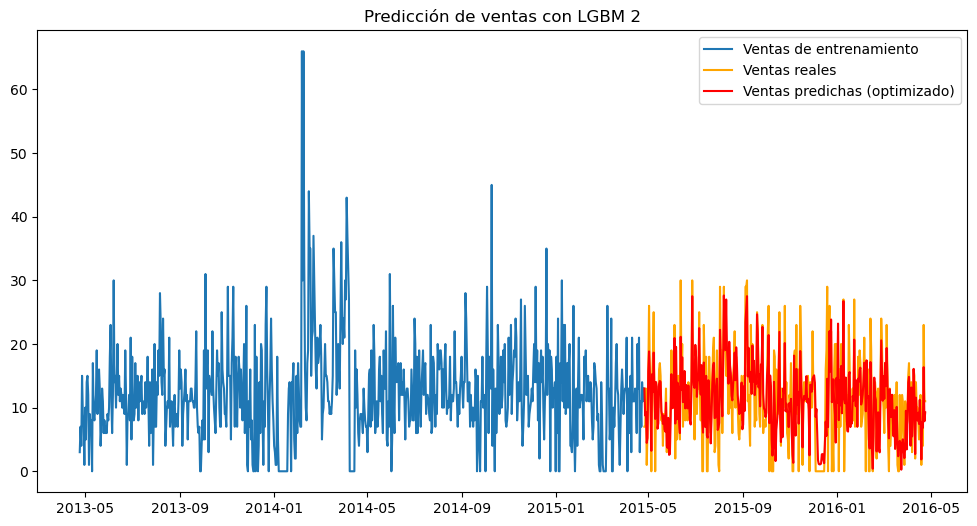

In [215]:
# Graficar las ventas de entrenamiento, las ventas reales y las predicciones del modelo optimizado
plt.figure(figsize=(12, 6))

# Graficar las ventas de entrenamiento
plt.plot(y_train.index, y_train.values, label='Ventas de entrenamiento')

# Graficar las ventas reales
plt.plot(y_test.index, y_test.values, label='Ventas reales', color='orange')

# Graficar las ventas predichas por el modelo optimizado LightGBM
plt.plot(y_test.index, y_pred_opt, label='Ventas predichas (optimizado)', color='red')

# Añadir leyenda y título
plt.legend()
plt.title('Predicción de ventas con LGBM 2')

# Mostrar la gráfica
plt.show()

In [216]:
# Calcular MAE y RMSE
mae = mean_absolute_error(y_test, y_pred_opt)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_opt))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 3.245178299162152
RMSE: 4.170818059939881


                      Feature  Importance
16  sales_weighted_moving_avg        5136
3                 sales_lag_1        3230
4                 sales_lag_2        2962
17   monthly_cumulative_sales        2930
10           cumulative_sales        2594
7            sales_moving_avg        2447
14               day_of_month        2350
18                sales_lag_7        2213
11                day_of_week        1741
6                week_of_year        1457
5                       month         878
2                   has_event         140
8     sales_event_interaction         120
1                     snap_CA          55
13                    quarter          43
15                 is_weekend           5
0                  sell_price           0
12           price_volatility           0
9     price_promo_interaction           0


<Figure size 1000x600 with 0 Axes>

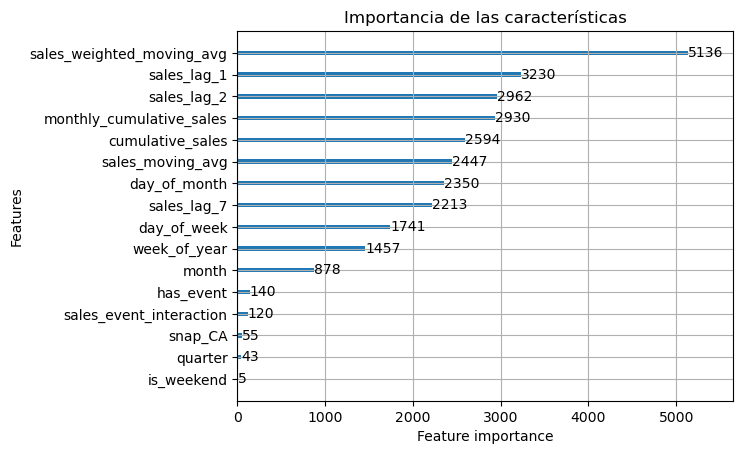

In [217]:
# Obtener la importancia de las características
importance = random_search.best_estimator_.feature_importances_
features = X_train.columns

# Crear un dataframe con la importancia de cada característica
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})

# Ordenar las características por importancia
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Mostrar la importancia de las características
print(feature_importance_df)



# Graficar la importancia de las características
plt.figure(figsize=(10, 6))
lgb.plot_importance(random_search.best_estimator_, max_num_features=20)
plt.title('Importancia de las características')
plt.show()

**Post-procesamiento: ajustar el 25 de diciembre con ventas 0 (la tienda cierra ese día)**

In [219]:
# Crear una copia de las predicciones para no alterar las originales, usando las fechas del conjunto de prueba
predicciones_ajustadas = pd.Series(y_pred_opt, index=y_test.index)

# Encontrar las fechas del 25 de diciembre en el conjunto de prueba
dias_cierre = (y_test.index.month == 12) & (y_test.index.day == 25)
dias_cierre_index = y_test.index[dias_cierre]

# Ajustar las predicciones a 0 en esas fechas específicas
predicciones_ajustadas[dias_cierre_index] = 0

# Verificar las predicciones ajustadas
print(predicciones_ajustadas[dias_cierre_index])

date
2015-12-25    0.0
dtype: float64


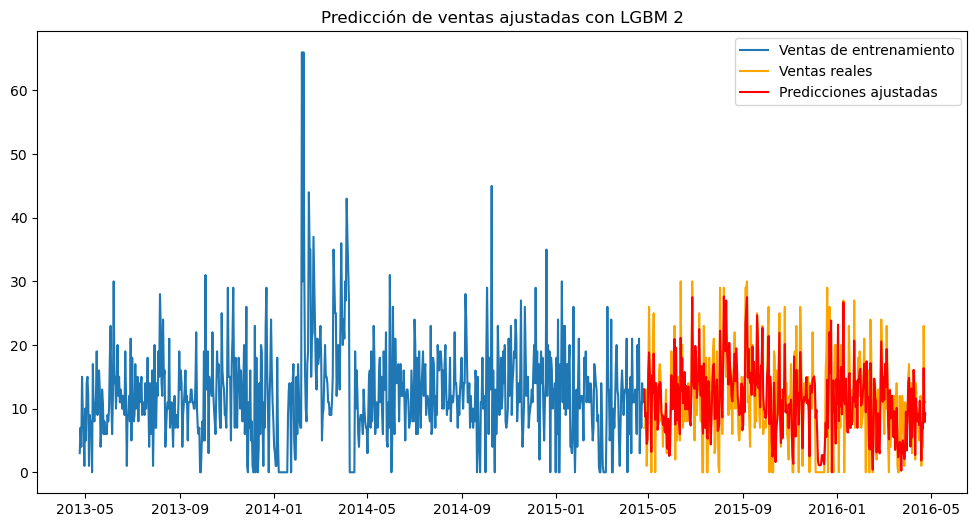

In [220]:
# Graficar las ventas de entrenamiento, las ventas reales y las predicciones ajustadas
plt.figure(figsize=(12, 6))

# Graficar las ventas de entrenamiento
plt.plot(y_train.index, y_train.values, label='Ventas de entrenamiento')

# Graficar las ventas reales
plt.plot(y_test.index, y_test.values, label='Ventas reales', color='orange')

# Graficar las predicciones ajustadas
plt.plot(y_test.index, predicciones_ajustadas, label='Predicciones ajustadas', color='red')

# Añadir leyenda y título
plt.legend()
plt.title('Predicción de ventas ajustadas con LGBM 2')
plt.show()

In [221]:
# Calcular MAE y RMSE para las predicciones ajustadas
mae_ajustado = mean_absolute_error(y_test, predicciones_ajustadas)
rmse_ajustado = np.sqrt(mean_squared_error(y_test, predicciones_ajustadas))

# Mostrar los resultados
print(f'MAE ajustado: {mae_ajustado}')
print(f'RMSE ajustado: {rmse_ajustado}')

MAE ajustado: 3.2154420918227227
RMSE ajustado: 4.131945661463851


#### **Guardar y exportar predicciones:**

In [223]:
# Guardar y_test y predicciones_ajustadas en archivos CSV
y_test.to_csv('y_test.csv')
predicciones_ajustadas.to_csv('predicciones_ajustadas.csv')

In [200]:
# Suponiendo que la columna 'date' ya está configurada como índice en el DataFrame 'df_foods_agg'.

# Crear las columnas 'year' y 'month' a partir del índice 'date'
df_foods_agg['year'] = df_foods_agg.index.year
df_foods_agg['month'] = df_foods_agg.index.month

# Agrupar por 'year' y 'month' y sumar 'sales_total'
df_sales_by_month_year = df_foods_agg.groupby(['year', 'month'])['sales_total'].sum().reset_index()

# Mostrar el DataFrame resultante
print(df_sales_by_month_year)

    year  month  sales_total
0   2013      4        17895
1   2013      5        88579
2   2013      6        95020
3   2013      7       100497
4   2013      8       106637
5   2013      9       101704
6   2013     10        92942
7   2013     11        86397
8   2013     12        91545
9   2014      1        87988
10  2014      2        79166
11  2014      3        90280
12  2014      4        93838
13  2014      5        92148
14  2014      6        92506
15  2014      7        98133
16  2014      8       101596
17  2014      9        91921
18  2014     10        95498
19  2014     11        92138
20  2014     12        86469
21  2015      1        89457
22  2015      2        78930
23  2015      3        87182
24  2015      4        89744
25  2015      5        95151
26  2015      6        91146
27  2015      7        93160
28  2015      8        94352
29  2015      9        88222
30  2015     10        92490
31  2015     11        78040
32  2015     12        77559
33  2016      

In [206]:
df_sales_by_month_year.head(40)

,year,month,sales_total
0,2013,4,17895
1,2013,5,88579
2,2013,6,95020
3,2013,7,100497
4,2013,8,106637
5,2013,9,101704
6,2013,10,92942
7,2013,11,86397
8,2013,12,91545
9,2014,1,87988


In [212]:

# Crear las columnas 'year' y 'month' a partir de 'date'
df_foods_2_347_agg['year'] = df_foods_2_347_agg['date'].dt.year

# Agrupar por 'year' y 'month' y sumar 'sales_total'
df_item_sales_by_month_year = df_foods_2_347_agg.groupby(['year', 'month'])['sales_total'].sum().reset_index()

# Mostrar el DataFrame resultante
print(df_item_sales_by_month_year)

    year  month  sales_total
0   2013      4           46
1   2013      5          293
2   2013      6          384
3   2013      7          350
4   2013      8          385
5   2013      9          303
6   2013     10          406
7   2013     11          409
8   2013     12          331
9   2014      1          155
10  2014      2          663
11  2014      3          537
12  2014      4          386
13  2014      5          377
14  2014      6          364
15  2014      7          394
16  2014      8          426
17  2014      9          351
18  2014     10          419
19  2014     11          430
20  2014     12          454
21  2015      1          370
22  2015      2          300
23  2015      3          287
24  2015      4          326
25  2015      5          345
26  2015      6          389
27  2015      7          366
28  2015      8          427
29  2015      9          432
30  2015     10          349
31  2015     11          364
32  2015     12          264
33  2016      

In [214]:
df_item_sales_by_month_year.head(40)

,year,month,sales_total
0,2013,4,46
1,2013,5,293
2,2013,6,384
3,2013,7,350
4,2013,8,385
5,2013,9,303
6,2013,10,406
7,2013,11,409
8,2013,12,331
9,2014,1,155
